In [1]:
import scipy.stats as stats
from scipy import special
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import trim as trim
# from utils import *
%pip install ipynb
from ipynb.fs.full.extractor_ARs import *
from ipynb.fs.full.UN_ARs import *


Note: you may need to restart the kernel to use updated packages.


## Part 1: utilities

This is a set of utility functions: transpositions and count occurrencies

In [2]:
def transformUN(indata: pd.DataFrame, region: str, rename: bool):
    
    """Transfor UN data in vertical series"""

    ddata = pd.DataFrame(indata.loc[indata.IPCCRegion==region])

    if "Variant" in ddata.columns:
        ddata = ddata.drop("Variant", axis=1)

    columns = ddata.Scenario.to_list()

    wt = ddata.transpose()

    wt = wt.reset_index()

    wtt = wt[3:]
    
    wtt.columns = ["year"] + columns
    
    wnew = pd.DataFrame()
    for c, col in enumerate(columns):
        data = pd.DataFrame(wtt[wtt.columns[0]])
        data = data.rename(columns={data.columns[0]: "Year"})
        data["Population"] = wtt[wtt.columns[c+1]]
        data["Labels"] = wtt.columns[c+1]
        wnew = pd.concat((wnew, data), axis=0)

    if rename:
        change={"Lower 80": "20", "Lower 95": "5", "Median": "50", "Upper 80": "80", "Upper 95": "95"}
        for ch in change.keys():
            wnew["Labels"] = wnew["Labels"].replace(ch, change[ch])
                    
    return (wnew)

def transformUNminmax(indata: pd.DataFrame, region: str, rename: bool):
    """Transfor UN data in vertical series
    and select scenarios with max and min population in 2100"""
    sel_series = [] #list to append the scenrios fulfilling requirements
    undata = transformUN(indata, region, rename)
    max_2100 = pd.DataFrame(undata.loc[undata.Year==2100]["Population"]).max()
    sel_series.append(list(set(undata.loc[undata.Population==max_2100.values[0]]["Labels"]))[0])
    min_2100 = pd.DataFrame(undata.loc[undata.Year==2100]["Population"]).min()
    sel_series.append(list(set(undata.loc[undata.Population==min_2100.values[0]]["Labels"]))[0])
    undata = pd.DataFrame(undata.loc[undata.Labels.isin(sel_series)])
    return undata, sel_series

def transformAR(indata: pd.DataFrame, region: str, dataset: str, threshold: float, years: list):
    """Transforms indata ARs from having years in columns
    to having years in rows"""
    ar = pd.DataFrame(indata.loc[indata.Variable == "Population"])
    ared = pd.DataFrame(ar.loc[ar.Region == region])
    arnew = pd.DataFrame()
    for year in years:
        data = pd.DataFrame(ared[str(year)])
        data["Year"] = year
        data = data.rename(columns = {str(year): "Population"})
        data = pd.DataFrame(data.loc[data.Population < threshold])
        data["Series"] = dataset
        arnew = pd.concat((arnew,data))
    return arnew

def transformSSP(indata, region, years, variable):
    """Transfor UN data in horizontal series"""

    syears = [str(y) for y in years]

    columns = ["MODEL"] + ["SCENARIO"] + ["IPCCRegion"] + syears

    indata = indata.groupby(["MODEL", "SCENARIO","IPCCRegion"])[syears].sum().reset_index()
    wout = pd.DataFrame()
    models = list(set(indata.MODEL))
    scenarios = ["SSP1", "SSP2", "SSP3", "SSP4", "SSP5"]
    for model in models:
        for scenario in scenarios:
            wt = pd.DataFrame(indata.loc[(indata.IPCCRegion == region) & (indata.MODEL == model) & (indata.SCENARIO==scenario)])
            wt = wt[columns]
            wt.columns = ["Model", "Scenario", "IPCCRegion"] + syears
            wtt = wt.transpose()
            wts =  pd.DataFrame(wtt.loc[wtt.index.isin(syears)])
            wts.columns = [variable]
            wts["Model"] = model
            wts["Scenario"] = scenario
            wout = pd.concat((wout, wts))
    wout = wout.reset_index()
    wout.columns = ["sYear", variable, "Model", "Scenario"]
    return (wout)

def readSSP():
    """Read Shared Socioeconomic Pathays data from folder data\SSP
    Returns:
    SSPpop: A dataframe with SSP population
    SSPgdp: A dataframe with SSP GDP,
    SSPgroups: A dataframe with SSP population, grouped by MODEL and SCENARIO
    SSPgdpgroups: A dataframe with SSP GDP, grouped by MODEL and SCENARIO
    codes: dictionary with ISO code and country names
    scenarios: dictionary scenario names and variants
    """
    codefile  = "codes_and_country_names.csv" 
    sspfile = "SspDb_country_data_2013-06-12.csv"
    folder = r'data/SSP'
    incodes = pd.read_csv(os.path.join(folder, codefile))
    SSP = pd.read_csv(os.path.join(folder, sspfile))

    SSP["Country"] = SSP["REGION"]
    columns = SSP.columns[:5].to_list() +["Country"] + [str(y) for y in years]
    SSP = SSP[columns]
    regions = list(set(SSP["REGION"]))
    incodes.columns = ["ISO", "Country"]

    keys=list(incodes.ISO)
    values=list(incodes.Country)
    codes = {k:values[keys.index(k)] for k in keys}

    UNreg  =       ["Burundi",
                    "Comoros",
                    "Djibouti",
                    "Eritrea",
                    "Ethiopia",
                    "Kenya",
                    "Madagascar",
                    "Malawi",
                    "Mauritius",
                    "Mayotte",
                    "Mozambique",
                    "Réunion",
                    "Rwanda",
                    "Seychelles",
                    "Somalia",
                    "South Sudan",
                    "Uganda",
                    "United Republic of Tanzania",
                    "Zambia",
                    "Zimbabwe",
                    "Angola",
                    "Cameroon",
                    "Central African Republic",
                    "Chad",
                    "Congo",
                    "Democratic Republic of the Congo",
                    "Equatorial Guinea",
                    "Gabon",
                    "Sao Tome and Principe",
                    "Algeria",
                    "Egypt",
                    "Libya",
                    "Morocco",
                    "Sudan",
                    "Tunisia",
                    "Western Sahara",
                    "Botswana",
                    "Eswatini",
                    "Lesotho",
                    "Namibia",
                    "South Africa",
                    "Benin",
                    "Burkina Faso",
                    "Cabo Verde",
                    "Côte d'Ivoire",
                    "Gambia",
                    "Ghana",
                    "Guinea",
                    "Guinea-Bissau",
                    "Liberia",
                    "Mali",
                    "Mauritania",
                    "Niger",
                    "Nigeria",
                    "Saint Helena",
                    "Senegal",
                    "Sierra Leone",
                    "Togo",
                    "Kazakhstan",
                    "Kyrgyzstan",
                    "Tajikistan",
                    "Turkmenistan",
                    "Uzbekistan",
                    "China",
                    "China, Hong Kong SAR",
                    "China, Macao SAR",
                    "China, Taiwan Province of China",
                    "Dem. People's Republic of Korea",
                    "Japan",
                    "Mongolia",
                    "Republic of Korea",
                    "Afghanistan",
                    "Bangladesh",
                    "Bhutan",
                    "India",
                    "Iran (Islamic Republic of)",
                    "Maldives",
                    "Nepal",
                    "Pakistan",
                    "Sri Lanka",
                    "Brunei Darussalam",
                    "Cambodia",
                    "Indonesia",
                    "Lao People's Democratic Republic",
                    "Malaysia",
                    "Myanmar",
                    "Philippines",
                    "Singapore",
                    "Thailand",
                    "Timor-Leste",
                    "Viet Nam",
                    "Armenia",
                    "Azerbaijan",
                    "Bahrain",
                    "Cyprus",
                    "Georgia",
                    "Iraq",
                    "Israel",
                    "Jordan",
                    "Kuwait",
                    "Lebanon",
                    "Oman",
                    "Qatar",
                    "Saudi Arabia",
                    "State of Palestine",
                    "Syrian Arab Republic",
                    "Türkiye",
                    "United Arab Emirates",
                    "Yemen",
                    "Belarus",
                    "Bulgaria",
                    "Czechia",
                    "Hungary",
                    "Poland",
                    "Republic of Moldova",
                    "Romania",
                    "Russian Federation",
                    "Slovakia",
                    "Ukraine",
                    "Denmark",
                    "Estonia",
                    "Faroe Islands",
                    "Finland",
                    "Guernsey",
                    "Iceland",
                    "Ireland",
                    "Isle of Man",
                    "Jersey",
                    "Latvia",
                    "Lithuania",
                    "Norway",
                    "Sweden",
                    "United Kingdom",
                    "Albania",
                    "Andorra",
                    "Bosnia and Herzegovina",
                    "Croatia",
                    "Gibraltar",
                    "Greece",
                    "Holy See",
                    "Italy",
                    "Kosovo (under UNSC res. 1244)",
                    "Malta",
                    "Montenegro",
                    "North Macedonia",
                    "Portugal",
                    "San Marino",
                    "Serbia",
                    "Slovenia",
                    "Spain",
                    "Austria",
                    "Belgium",
                    "France",
                    "Germany",
                    "Liechtenstein",
                    "Luxembourg",
                    "Monaco",
                    "Netherlands",
                    "Switzerland",
                    "Anguilla",
                    "Antigua and Barbuda",
                    "Aruba",
                    "Bahamas",
                    "Barbados",
                    "Bonaire, Sint Eustatius and Saba",
                    "British Virgin Islands",
                    "Cayman Islands",
                    "Cuba",
                    "Curaçao",
                    "Dominica",
                    "Dominican Republic",
                    "Grenada",
                    "Guadeloupe",
                    "Haiti",
                    "Jamaica",
                    "Martinique",
                    "Montserrat",
                    "Puerto Rico",
                    "Saint Barthélemy",
                    "Saint Kitts and Nevis",
                    "Saint Lucia",
                    "Saint Martin (French part)",
                    "Saint Vincent and the Grenadines",
                    "Sint Maarten (Dutch part)",
                    "Trinidad and Tobago",
                    "Turks and Caicos Islands",
                    "United States Virgin Islands",
                    "Belize",
                    "Costa Rica",
                    "El Salvador",
                    "Guatemala",
                    "Honduras",
                    "Mexico",
                    "Nicaragua",
                    "Panama",
                    "Argentina",
                    "Bolivia (Plurinational State of)",
                    "Brazil",
                    "Chile",
                    "Colombia",
                    "Ecuador",
                    "Falkland Islands (Malvinas)",
                    "French Guiana",
                    "Guyana",
                    "Paraguay",
                    "Peru",
                    "Suriname",
                    "Uruguay",
                    "Venezuela (Bolivarian Republic of)",
                    "Bermuda",
                    "Canada",
                    "Greenland",
                    "Saint Pierre and Miquelon",
                    "United States of America",
                    "Australia",
                    "New Zealand",
                    "Fiji",
                    "New Caledonia",
                    "Papua New Guinea",
                    "Solomon Islands",
                    "Vanuatu",
                    "Guam",
                    "Kiribati",
                    "Marshall Islands",
                    "Micronesia (Fed. States of)",
                    "Nauru",
                    "Northern Mariana Islands",
                    "Palau",
                    "American Samoa",
                    "Cook Islands",
                    "French Polynesia",
                    "Niue",
                    "Samoa",
                    "Tokelau",
                    "Tonga",
                    "Tuvalu",
                    "Wallis and Futuna Islands",
                    ]


    checked = [name for name in list(codes.values()) if name not in UNreg]

    if len(checked) > 0:
        print (checked)
        print ("These countries are not mapped ", checked)


    scenarios = {"SSP3_v9_130115"	:	"SSP3"	,
                "SSP1_v9_130219"	:	"SSP1"	,
                "SSP2_v9_130219"	:	"SSP2"	,
                "SSP3_v9_130219"	:	"SSP3"	,
                "SSP4_v9_130219"	:	"SSP4"	,
                "SSP5_v9_130219"	:	"SSP5"	,
                "SSP1_v9_130325"	:	"SSP1"	,
                "SSP2_v9_130325"	:	"SSP2"	,
                "SSP3_v9_130325"	:	"SSP3"	,
                "SSP4_v9_130325"	:	"SSP4"	,
                "SSP5_v9_130325"	:	"SSP5"	,
                "SSP1_v9_130424"	:	"SSP1"	,
                "SSP2_v9_130424"	:	"SSP2"	,
                "SSP3_v9_130424"	:	"SSP3"	,
                "SSP4_v9_130424"	:	"SSP4"	,
                "SSP5_v9_130424"	:	"SSP5"	,
                "SSP5_v9_130115"	:	"SSP5"	,
                "SSP1_v9_130115"	:	"SSP1"	,
                "SSP2_v9_130115"	:	"SSP2"	,
                "SSP4_v9_130115"	:	"SSP4"	,
                "SSP4d_v9_130115"	:	"SSP4"	}

    SSPpop = SSP.loc[SSP.VARIABLE == "Population"]
    SSPgdp  = SSP.loc[SSP.VARIABLE == "GDP|PPP"]

    SSPgroups = pd.DataFrame(SSPpop.groupby(["MODEL","SCENARIO"]).sum(numeric_only=True).reset_index())
    SSPgdpgroups  = pd.DataFrame(SSPgdp.groupby(["MODEL","SCENARIO"]).sum(numeric_only=True).reset_index())
    remove = "PIK GDP-32"
    SSPgroups = pd.DataFrame(SSPgroups.loc[SSPgroups.MODEL != remove])
    SSPgdpgroups = pd.DataFrame(SSPgdpgroups.loc[SSPgdpgroups.MODEL != remove])
    for o in scenarios.keys():
        SSPgroups["SCENARIO"]  = SSPgroups["SCENARIO"].replace(o, scenarios[o])
        SSPgdpgroups["SCENARIO"]  = SSPgdpgroups["SCENARIO"].replace(o, scenarios[o])
    SSPgroups["IPCCRegion"] = "WORLD"
    SSPgdpgroups["IPCCRegion"] = "WORLD"

    return (SSPpop, SSPgdp, SSPgroups, SSPgdpgroups, codes, scenarios)

def counts (data: pd.DataFrame, region: str):
    """Returns number of scenarios for each data input 
    and selected region"""
    datavar = data.loc[((data.Variable == "Population") & (data.Region == region))]
    datavar1 = datavar["2050"][datavar["2050"] > 0]
    vals2050 = len(datavar1)
    datavar2 = datavar["2100"][datavar["2100"] > 0]
    vals2100 = len(datavar2)
    name = list(set(data.Report))[0]
    dataout = pd.DataFrame(np.array([vals2050, vals2100]).reshape(2,1), 
            columns=["Scenario Number"], index=[name, name])
    dataout["Region"]=region
    dataout["Year"]=np.array([2050, 2100]).reshape(2,1)
    return dataout

def data_error(truedata: pd.DataFrame, 
               indata: pd.DataFrame, 
               year: float, 
               threshold: float,
               region: str, 
               dataset: str):
    """Gives error estimates on a regional scale"""
    """Estimate mean squared error"""
    """Data in input has year on horizontal"""
    """First transpose arrays"""
    """Errors estimated from UN mean"""
    """Estimate percent error dividing MAE, MSE, RMSE by true value"""

    ar = pd.DataFrame(indata.loc[indata.Variable == "Population"])
    ared = pd.DataFrame(ar.loc[ar.Region == region])
    y_pred = pd.DataFrame(ared.loc[ared[str(year)] < threshold])[str(year)]
    n = len(y_pred)
    y_new = transformUN(truedata, region, False)
    y_new = y_new.loc[(y_new.Year == year)]
    y_true = np.repeat(np.mean(y_new.Population), n)
    MAE = 100 * (np.sum(np.abs(y_true - y_pred))/(n-1)/np.mean(y_true))
    MSE = 100 * (np.sum(np.power((y_true - y_pred),2))/(n-1)/np.mean(y_true))
    RMSE = 100 * (np.power(MSE, 0.5)/np.mean(y_true))
    return MAE, MSE, RMSE

def trimsample (sample: np.array,
                low: float,
                up: float):
    """Trims samples of data based on a defined percentage cut
    Values below or higher the relative cut are filtered out"""
    # mask the values
    trimmed = trim(sample, limits=(low, up), inclusive=(True, True), relative=True)
    # masked values substituted with zeros
    trimmed = trimmed.filled(0.0)
    # filter out zeros
    trimmed = trimmed[np.where(trimmed >0.0)]
    return trimmed

def pre_test (sample_0: np.array,
              sample_1: np.array,  
              low_0: float, 
              up_0: float, 
              low_1: float, 
              up_1: float, 
              function: str,
              qvalue=0):
    """Calculate the Welch test between two samples
    Or a sample and a value"""
    """Equivalent to 
    stats.ttest_ind(sample1, sample2, axis=0, equal_var=False, nan_policy='propagate',
    permutations=None, random_state=None, alternative="greater",
    trim=0)"""
    """Returns welch-test result, the degrees of freedom, and the p-value"""
    sample1 = trimsample(sample_0, low_0, up_0)
    sample2 = trimsample(sample_1, low_1, up_1)
    sample1 = np.reshape(np.asarray(sample1),-1)
    sample2 = np.reshape(np.asarray(sample2),-1)
    if function=="mean":
        v1 = np.mean(sample1)
        v2 = np.mean(sample2)
    if function=="std":
        v1 = np.std(sample1)
        v2 = np.std(sample2)
    if function=="quantile":
        v1 = np.quantile(sample1, qvalue)
        v2 = np.quantile(sample2, qvalue)

    s1 = np.var(sample1)
    s2 = np.var(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]

    return (v1, s1, n1, v2, s2, n2)

def welch_test (v1: float,
                s1: float, 
                n1: int, 
                v2: float, 
                s2: float, 
                n2: int, 
                alternative: str):
    vn1 = v1 / n1
    vn2 = v2 / n2
    denom = np.sqrt(vn1 + vn2)

    if n2 > 1:
        df = np.power((vn1 + vn2),2) / (np.power((vn1),2) / (n1 -1) + np.power((vn2),2) / (n2-1))
    else:
        df = np.power((s1/n1 + s2/n2),2) / (np.power((s1/n1),2) / (n1 -1) )

    d = v1-v2
    with np.errstate(divide='ignore', invalid='ignore'):
        welch_t = np.divide(d, denom)
    if alternative == 'less':
        pval = special.stdtr(df, welch_t)
    elif alternative == 'greater':
        pval = special.stdtr(df, -welch_t)
    elif alternative == 'two-sided':
        pval = special.stdtr(df, -np.abs(welch_t))*2

    return (welch_t, df, pval)

def databdiff(database1: pd.DataFrame,
             name1: str, 
             database2: pd.DataFrame, 
             name2: str,
             region: str,
             variable: str,
             threshold: float,
             function: str,
             qvalue: float,
             alternative: str,
             low_0: float,
             up_0: float,
             low_1: float,
             up_1: float):
    """Represents differences between databases"""

    out = pd.DataFrame()

    for year in years:
        sample1 = database1.loc[((database1.Variable==variable) & (database1.Region==region))][str(year)]
        sample1 = pd.DataFrame(sample1.loc[sample1 <= threshold])
        sample2 = database2.loc[((database2.Variable==variable)) & (database2.Region==region)][str(year)]
        sample2 = pd.DataFrame(sample2.loc[sample2 <= threshold])

        if function=="mean":
            mn = np.mean(sample2, axis=0).values[0]
        if function=="std":
            mn = np.std(sample2, axis=0).values[0]
        if function=="quantile":
            mn = sample2.quantile(qvalue)
        newsample1 = sample1 - mn
        pos1 = newsample1.agg(lambda x: sum(x > 0)).sum()
        neg1 = newsample1.agg(lambda x: sum(x < 0)).sum()
        v1, s1, n1, v2, s2, n2 = pre_test(sample1, sample2, low_0, up_0, low_1, up_1, function, qvalue)
        welch_t, df, pval = welch_test(v1, s1, n1, v2, s2, n2, alternative)
        p_value = np.round(pval,3)

        data = pd.DataFrame({"High": [pos1], "Low": [neg1], "p_value": [p_value]}, index=[str(year)])
        out = pd.concat((out, data), axis=0)
        out = out[["Low", "High", "p_value"]]

    return out

# joint prob plot v1

def jointprobchart(indata, undata, region, dataset, threshold):
    ar = pd.DataFrame(indata.loc[indata.Variable == "Population"])
    ared = pd.DataFrame(ar.loc[ar.Region == region])
    arnew = pd.DataFrame()
    for year in years:
        data = pd.DataFrame(ared[str(year)])
        data["Year"] = year
        data = data.rename(columns = {str(year): "Population"})
        data = pd.DataFrame(data.loc[data.Population < threshold])
        data["Series"] = dataset
        arnew = pd.concat((arnew,data))

    #wnewt = pd.concat((wnew,ar6new))
    g = sns.JointGrid(data=arnew, x="Year", y="Population")
    g.plot_joint(sns.scatterplot)
    g.plot_marginals(sns.kdeplot,fill=True )
    g.ax_marg_x.remove()

    w5 = pd.DataFrame(undata.loc[undata.Series=="5"])
    g.x = w5.Year
    g.y = w5.Population
    g.plot_joint(plt.plot, color="goldenrod")

    w5 = pd.DataFrame(undata.loc[undata.Series=="20"])
    g.x = w5.Year
    g.y = w5.Population
    g.plot_joint(plt.plot, color="orange")

    w5 = pd.DataFrame(undata.loc[undata.Series=="50"])
    g.x = w5.Year
    g.y = w5.Population
    g.plot_joint(plt.plot, color="chocolate")

    w5 = pd.DataFrame(undata.loc[undata.Series=="80"])
    g.x = w5.Year
    g.y = w5.Population
    g.plot_joint(plt.plot, color="indianred")

    w5 = pd.DataFrame(undata.loc[undata.Series=="95"])
    g.x = w5.Year
    g.y = w5.Population
    g.plot_joint(plt.plot, color="crimson")
    plttitle = region + " - " + dataset

    plt.title(plttitle)
    plt.xticks(years, years, rotation="vertical")
    plt.ylabel("Population, billion")

# joint plot v1
def joinplot(indata: pd.DataFrame, region: str, threshold: float,
    undata: pd.DataFrame, dataset: str, years: list, limit: float):
    ar = pd.DataFrame(indata.loc[indata.Variable == "Population"])
    ared = pd.DataFrame(ar.loc[ar.Region == region])

    arnew = pd.DataFrame()
    for year in years:
        data = pd.DataFrame(ared[str(year)])
        # data = data.rename(columns = {str(year): "Population"})
        data = pd.DataFrame(data.loc[data[str(year)] < threshold])
        data.columns = ["Population"]
        data["Labels"] = dataset
        data["Year"] = year
        arnew = pd.concat((arnew,data), axis=0)


    features = {"alpha": 0.6, "figsize": (5,10), "linewidth": 0.1, "overlap": 3}

    ax = sns.FacetGrid(data, height = 6)
    # boxplot
    ax = sns.boxplot(x="Year", y="Population", data=arnew, palette="pastel")
    # add stripplot
    ax = sns.stripplot(x="Year", y='Population', data=arnew, color="orange", jitter=0.1, size=1.0)


    w5 = pd.DataFrame(undata.loc[undata.Labels=="5"])
    ystring = [str(y) for y in years]
    w5["sYear"] = pd.Series(ystring)
    sns.lineplot(data = w5[["Population", "sYear"]], y = w5.Population.values, x = w5.sYear.values, color="green", label="5 perc")


    w5 = pd.DataFrame(undata.loc[undata.Labels=="20"])
    ystring = [str(y) for y in years]
    w5["sYear"] = ystring 
    sns.lineplot(data = w5[["Population", "sYear"]], y = w5.Population.values, x = w5.sYear.values, color="turquoise", label="20 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="50"])
    ystring = [str(y) for y in years]
    w5["sYear"] = ystring 
    sns.lineplot(data = w5[["Population", "sYear"]], y = w5.Population.values, x = w5.sYear.values, color="royalblue", label="50 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="80"])
    ystring = [str(y) for y in years]
    w5["sYear"] = ystring 
    sns.lineplot(data = w5[["Population", "sYear"]], y = w5.Population.values, x = w5.sYear.values, color="blue", label="80 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="95"])
    ystring = [str(y) for y in years]
    w5["sYear"] = ystring 
    sns.lineplot(data = w5[["Population", "sYear"]], y = w5.Population.values, x = w5.sYear.values, color="darkorchid", label="95 perc")
    plt.legend()

    title = dataset + " - " + region

    plt.ylabel("Population, billion inhab")
    
    plt.title(title)

    ax.set(ylim=(5, limit))

# joint plot v2
def joinplot2(indata: pd.DataFrame, region: str, threshold: float,
    undata: pd.DataFrame, dataset: str, years: list, limit: float):
    ar = pd.DataFrame(indata.loc[indata.Variable == "Population"])
    ared = pd.DataFrame(ar.loc[ar.Region == region])

    arnew = pd.DataFrame()
    for year in years:
        data = pd.DataFrame(ared[str(year)])
        # data = data.rename(columns = {str(year): "Population"})
        data = pd.DataFrame(data.loc[data[str(year)] < threshold])
        data.columns = ["Population"]
        data["Labels"] = dataset
        data["Year"] = year
        arnew = pd.concat((arnew,data), axis=0)

    features = {"alpha": 0.6, "figsize": (5,10), "linewidth": 0.1, "overlap": 3}

    ax = sns.JointGrid(data=arnew, x="Year", y="Population",ylim=(5,limit))

    # add stripplot
    ax.plot_joint(sns.boxplot, palette="pastel")
    ax.plot_joint(sns.stripplot, color="orange", jitter=0.1, size=1.0)
    ax.plot_marginals(sns.kdeplot,fill=True )
    ax.ax_marg_x.remove()
    # ax = sns.stripplot(x="Year", y='Population', data=arnew, color="orange", jitter=0.1, size=1.0)

    ystring = [str(y) for y in years]
    w5 = pd.DataFrame(undata.loc[undata.Labels=="5"])
    w5["sYear"] = ystring 
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="green", label= "5 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="20"])
    w5["sYear"] = ystring 
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="turquoise", label= "20 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="50"])
    w5["sYear"] = ystring 
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="royalblue", label= "50 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="80"])
    w5["sYear"] = ystring 
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="blue", label= "80 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="95"])
    w5["sYear"] = ystring 
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="darkorchid", label= "95 perc")

    plt.legend()
    title = dataset + " - " + region
    plt.ylabel("Population, billion inhab")

# joint plot v3
def joinplot3(indata: pd.DataFrame, region: str, threshold: list,
    undata: pd.DataFrame, scaler: float, dataset: str, years: list, btitle: bool, ylim: tuple):
    ar = pd.DataFrame(indata.loc[indata.Variable == "Population"])
    ared = pd.DataFrame(ar.loc[ar.Region == region])

    arnew = pd.DataFrame()
    for year in years: 
        data = pd.DataFrame(ared[str(year)]).fillna(method="pad")
        data = pd.DataFrame(data[data >= data.quantile(threshold[0])]).dropna(axis=0)
        data = pd.DataFrame(data[data <= data.quantile(threshold[1])]).dropna(axis=0)
        data = pd.DataFrame(data[data < threshold[2]]).dropna(axis=0)
        # data = data.rename(columns = {str(year): "Population"})
        data.columns = ["Population"]
        data["Series"] = dataset
        data["Year"] = year
        arnew = pd.concat((arnew,data.reset_index()), axis=0)

    features = {"alpha": 0.6, "figsize": (5,10), "linewidth": 0.1, "overlap": 3}

    ax = sns.JointGrid(data=arnew, x="Year", y="Population",ylim=(5,limit))

    # add stripplot
    ax.plot_joint(sns.boxplot, palette="pastel")
    ax.plot_joint(sns.stripplot, color="orange", jitter=0.1, size=1.0)
    ax.plot_marginals(sns.kdeplot,fill=True )
    ax.ax_marg_x.remove()
    # ax = sns.stripplot(x="Year", y='Population', data=arnew, color="orange", jitter=0.1, size=1.0)

    ystring = [str(y) for y in years]
    w5 = pd.DataFrame(undata.loc[undata.Labels=="5"])
    w5["sYear"] = ystring 
    w5["Population"] *= 1/1000
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="green", label= "5 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="20"])
    w5["sYear"] = ystring 
    w5["Population"] *= 1/1000
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="turquoise", label= "20 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="50"])
    w5["sYear"] = ystring 
    w5["Population"] *= 1/1000
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="royalblue", label= "50 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="80"])
    w5["sYear"] = ystring 
    w5["Population"] *= 1/1000
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="blue", label= "80 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="95"])
    w5["sYear"] = ystring 
    w5["Population"] *= 1/1000
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="darkorchid", label= "95 perc")

    plt.legend()
    if btitle:
        title = dataset + " - " + region
        plt.title(title)

    plt.ylabel("Population, billion inhab")
    plt.ylim(ylim)

    plt.title(title)

# joint plot 3b
def joinplot3b(indata: pd.DataFrame, region: str, threshold: list, undata: pd.DataFrame, scaler: float,
               dataset: str, years: list, btitle: bool, ylim: tuple):
    ar = pd.DataFrame(indata.loc[indata.Variable == "Population"])
    ared = pd.DataFrame(ar.loc[ar.Region == region])

    arnew = pd.DataFrame()
    for year in years: 
        data = pd.DataFrame(ared[str(year)]).fillna(method="pad")
        data = pd.DataFrame(data[data >= data.quantile(threshold[0])]).dropna(axis=0)
        data = pd.DataFrame(data[data <= data.quantile(threshold[1])]).dropna(axis=0)
        data = pd.DataFrame(data[data < threshold[2]]).dropna(axis=0)
        # data = data.rename(columns = {str(year): "Population"})
        data.columns = ["Population"]
        data["Series"] = dataset
        data["Year"] = year
        arnew = pd.concat((arnew,data.reset_index()), axis=0)

    features = {"alpha": 0.6, "figsize": (5,10), "linewidth": 0.1, "overlap": 3}

    ax = sns.JointGrid(data=arnew, x="Year", y="Population")

    # add stripplot
    ax.plot_joint(sns.boxplot, palette="pastel")
    ax.plot_joint(sns.stripplot, color="orange", jitter=0.1, size=1.0)
    ax.plot_marginals(sns.kdeplot,fill=True )
    ax.ax_marg_x.remove()
    # ax = sns.stripplot(x="Year", y='Population', data=arnew, color="orange", jitter=0.1, size=1.0)

    colors = ["teal", "indigo", "crimson", "darkmagenta", "dodgerblue"]
    # for scenario in scenarios: 
    
    ystring = [str(y) for y in years]

    w = transformSSP(undata, region, years, "Population")
    w["Population"] *= 1/scaler
    scenarios = ["SSP1", "SSP2", "SSP3", "SSP4", "SSP5"]
    for s, scenario in enumerate(scenarios):
        ax.x = w.loc[w.Scenario==scenario].sYear
        ax.y = w.loc[w.Scenario==scenario]["Population"]
        ax.plot_joint(sns.lineplot, color=colors[s], label=scenario)


    if btitle:
        title = dataset + " - " + region
        plt.title(title, loc='right')
    plt.ylim(ylim)
    return ax

# joint plot v4
def joinplot4(indata: pd.DataFrame, region: str, threshold: float,
    undata: pd.DataFrame, dataset: str, years: list, limit: float,
    sel_scenarios):
    """"Plots ARs and UN databases probabilistic
    in addition to extreme deterministic scenarios"""
    ar = pd.DataFrame(indata.loc[indata.Variable == "Population"])
    ared = pd.DataFrame(ar.loc[ar.Region == region])

    arnew = pd.DataFrame()
    for year in years:
        data = pd.DataFrame(ared[str(year)])
        # data = data.rename(columns = {str(year): "Population"})
        data = pd.DataFrame(data.loc[data[str(year)] < threshold])
        data.columns = ["Population"]
        data["Labels"] = dataset
        data["Year"] = year
        arnew = pd.concat((arnew,data), axis=0)

    features = {"alpha": 0.6, "figsize": (5,10), "linewidth": 0.1, "overlap": 3}

    ax = sns.JointGrid(data=arnew, x="Year", y="Population",ylim=(5,limit))

    # add stripplot
    ax.plot_joint(sns.boxplot, palette="pastel")
    ax.plot_joint(sns.stripplot, color="orange", jitter=0.1, size=1.0)
    ax.plot_marginals(sns.kdeplot,fill=True )
    ax.ax_marg_x.remove()

    ystring = [str(y) for y in years]
    w5 = pd.DataFrame(undata.loc[undata.Labels=="5"])
    w5["sYear"] = ystring 
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="green", label= "5 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="20"])
    w5["sYear"] = ystring 
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="turquoise", label= "20 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="50"])
    w5["sYear"] = ystring 
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="royalblue", label= "50 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="80"])
    w5["sYear"] = ystring 
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="blue", label= "80 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="95"])
    w5["sYear"] = ystring 
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="darkorchid", label= "95 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels==sel_scenarios[0]])
    w5["sYear"] = ystring 
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="crimson", label=sel_scenarios[0])

    w5 = pd.DataFrame(undata.loc[undata.Labels==sel_scenarios[1]])
    w5["sYear"] = ystring 
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="olive", label=sel_scenarios[1])

    plt.legend()
    title = dataset + " - " + region
    plt.ylabel("Population, billion inhab")

def joinplot4b(indata: pd.DataFrame, region: str, threshold: list, undata: pd.DataFrame, scaler: float,
               dataset: str, years: list, btitle: bool, ylim: tuple, sel_scenarios: list):
    ar = pd.DataFrame(indata.loc[indata.Variable == "Population"])
    ared = pd.DataFrame(ar.loc[ar.Region == region])

    arnew = pd.DataFrame()
    for year in years: 
        data = pd.DataFrame(ared[str(year)]).fillna(method="pad")
        data = pd.DataFrame(data[data >= data.quantile(threshold[0])]).dropna(axis=0)
        data = pd.DataFrame(data[data <= data.quantile(threshold[1])]).dropna(axis=0)
        data = pd.DataFrame(data[data < threshold[2]]).dropna(axis=0)
        # data = data.rename(columns = {str(year): "Population"})
        data.columns = ["Population"]
        data["Series"] = dataset
        data["Year"] = year
        arnew = pd.concat((arnew,data.reset_index()), axis=0)

    features = {"alpha": 0.6, "figsize": (5,10), "linewidth": 0.1, "overlap": 3}

    ax = sns.JointGrid(data=arnew, x="Year", y="Population",ylim=(5,limit))

    # add stripplot
    ax.plot_joint(sns.boxplot, palette="pastel")
    ax.plot_joint(sns.stripplot, color="orange", jitter=0.1, size=1.0)
    ax.plot_marginals(sns.kdeplot,fill=True )
    ax.ax_marg_x.remove()
    # ax = sns.stripplot(x="Year", y='Population', data=arnew, color="orange", jitter=0.1, size=1.0)

    ystring = [str(y) for y in years]
    w5 = pd.DataFrame(undata.loc[undata.Labels=="5"])
    w5["sYear"] = ystring 
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="green", label= "5 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="20"])
    w5["sYear"] = ystring 
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="turquoise", label= "20 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="50"])
    w5["sYear"] = ystring 
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="royalblue", label= "50 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="80"])
    w5["sYear"] = ystring 
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="blue", label= "80 perc")

    w5 = pd.DataFrame(undata.loc[undata.Labels=="95"])
    w5["sYear"] = ystring 
    ax.x = w5.sYear
    ax.y = w5.Population
    ax.plot_joint(plt.plot, color="darkorchid", label= "95 perc")

    # w5 = pd.DataFrame(undata.loc[undata.Labels==sel_scenarios[0]])
    # w5["sYear"] = ystring 
    # ax.x = w5.sYear
    # ax.y = w5.Population
    # ax.plot_joint(plt.plot, color="crimson", label=sel_scenarios[0])

    # w5 = pd.DataFrame(undata.loc[undata.Labels==sel_scenarios[1]])
    # w5["sYear"] = ystring 
    # ax.x = w5.sYear
    # ax.y = w5.Population
    # ax.plot_joint(plt.plot, color="olive", label=sel_scenarios[1])

    plt.legend()
    title = dataset + " - " + region
    plt.ylabel("Population, million inhab")

    if btitle:
        title = dataset + " - " + region
        plt.title(title, loc='right')
    plt.ylim(ylim)
    return ax

## Part 2: data loading

The first block below uploads the IPCC databases, AR5 (ar5HI), SR 1.5 (ar15HI), and AR6 (ar6HI). 
In AR6, the 5-region, 6-region, and 10-region version of AR6 are uploaded.

The second block below uploads the United Nation (UN) probabilistic projections:
'- w#, r#, and o# map the global, the regional, and the "rest of the world" region in the UN data
'- the suffix 20XY defines the year of the probabilistic projction revision
'- the suffix #_1, #_5, #_6, #_10 refers to the number of regions of the IPCC into which countries are mapped

The third block below uploads the United Nation population scnearions (deterministic), following the same rules for suffixes as the probabilisic projections.
'- w2015_1ext, w2019_1ext, w2022_1ext are the global probabilistic projection of the United Nations, including the highest and lowest deterministic scenarios.

In [3]:
years = [2020, 2030, 2040, 2050, 2060, 2070,
            2080, 2090, 2100]

ar5HI, ar15HI, ar6HI = nonharmARsextractor()

ar5HI.Region = ar5HI.Region.replace("MAF", "R5MAF")
ar5HI.Region = ar5HI.Region.replace("REF", "R5REF")
ar5HI.Region = ar5HI.Region.replace("LAM", "R5LAM")
ar5HI.Region = ar5HI.Region.replace("OECD90", "R5OECD90+EU")
ar5HI.Region = ar5HI.Region.replace("ASIA", "R5ASIA")
ar5HI.Region = ar5HI.Region.replace("World", "WORLD")
ar6HI.Region = ar6HI.Region.replace("World", "WORLD")
ar15HI.Region = ar15HI.Region.replace("World", "WORLD")

ar6reg5HI, ar6reg6HI, ar6reg10HI = nonharmARregsextractor()

In [4]:
years = [2020, 2030, 2040, 2050, 2060, 2070,
            2080, 2090, 2100]

filenames =["UN_PPP2015_Output_PopTot_Probabilistic.xls",
            "UN_PPP2017_Output_PopTot_Probabilistic.xls",
            "UN_PPP2019_Output_PopTot_Probabilistic.xlsx",
            "UN_PPP2022_Output_PopTot_Probabilistic.xlsx"]


w2015_1, r2015_1, o2015_1 = un_tseries(years, filenames[0], 1)
w2017_1, r2017_1, o2017_1 = un_tseries(years, filenames[1], 1)
w2019_1, r2019_1, o2019_1 = un_tseries(years, filenames[2], 1)
w2022_1, r2022_1, o2022_1 = un_tseries2022 (years, filenames[3], 1)

w2015_6, r2015_6, o2015_6 = un_tseries(years, filenames[0], 6)
w2017_6, r2017_6, o2017_6 = un_tseries(years, filenames[1], 6)
w2019_6, r2019_6, o2019_6 = un_tseries(years, filenames[2], 6)
w2022_6, r2022_6, o2022_6 = un_tseries2022 (years, filenames[3], 6)

w2015_5, r2015_5, o2015_5 = un_tseries(years, filenames[0], 5)
w2017_5, r2017_5, o2017_5 = un_tseries(years, filenames[1], 5)
w2019_5, r2019_5, o2019_5 = un_tseries(years, filenames[2], 5)
w2022_5, r2022_5, o2022_5 = un_tseries2022 (years, filenames[3], 5)

w2015_10, r2015_10, o2015_10 = un_tseries(years, filenames[0], 10)
w2017_10, r2017_10, o2017_10 = un_tseries(years, filenames[1], 10)
w2019_10, r2019_10, o2019_10 = un_tseries(years, filenames[2], 10)
w2022_10, r2022_10, o2022_10 = un_tseries2022 (years, filenames[3], 10)


In [5]:
wyears=un_extraction("WORLD") # this extractor gives columns as float rather than strings
syears = [str(y) for y in years if years != 2020]
year_rename = dict(zip(syears,years))
wyears=wyears.rename(columns=year_rename)

sel_versions = ['revision_2015', 'revision_2019', 'revision_2022']
wversion = pd.DataFrame(wyears.loc[wyears.Variant.isin(sel_versions)])

# add 2020
wversion.loc[wversion.Region=="WORLD", 2020] = pd.Series(np.unique(w2022_1[2020].values))

# add deterministic "Variant" to probabilistic databases
w2022_1["Variant"] = "revision_2022"
w2019_1["Variant"] = "revision_2019"
w2015_1["Variant"] = "revision_2015"


wversion.loc[wversion.Region=="WORLD", "IPCCRegion"] = wversion["Region"]
wversion = wversion.rename(columns={"Region": "UNRegion"})
columns = ["IPCCRegion", "Scenario", "Variant", "UNRegion", 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
w2022_1 = w2022_1[columns]
w2019_1 = w2019_1[columns]
w2015_1 = w2015_1[columns]
wversion = wversion[columns]

# Define extended databases with the external scenarios to probabilistic
w2022_1ext = pd.DataFrame(wversion.loc[wversion.Variant=="revision_2022"])
w2019_1ext = pd.DataFrame(wversion.loc[wversion.Variant=="revision_2019"])
w2015_1ext = pd.DataFrame(wversion.loc[wversion.Variant=="revision_2015"])


## Part 3: Figure 1

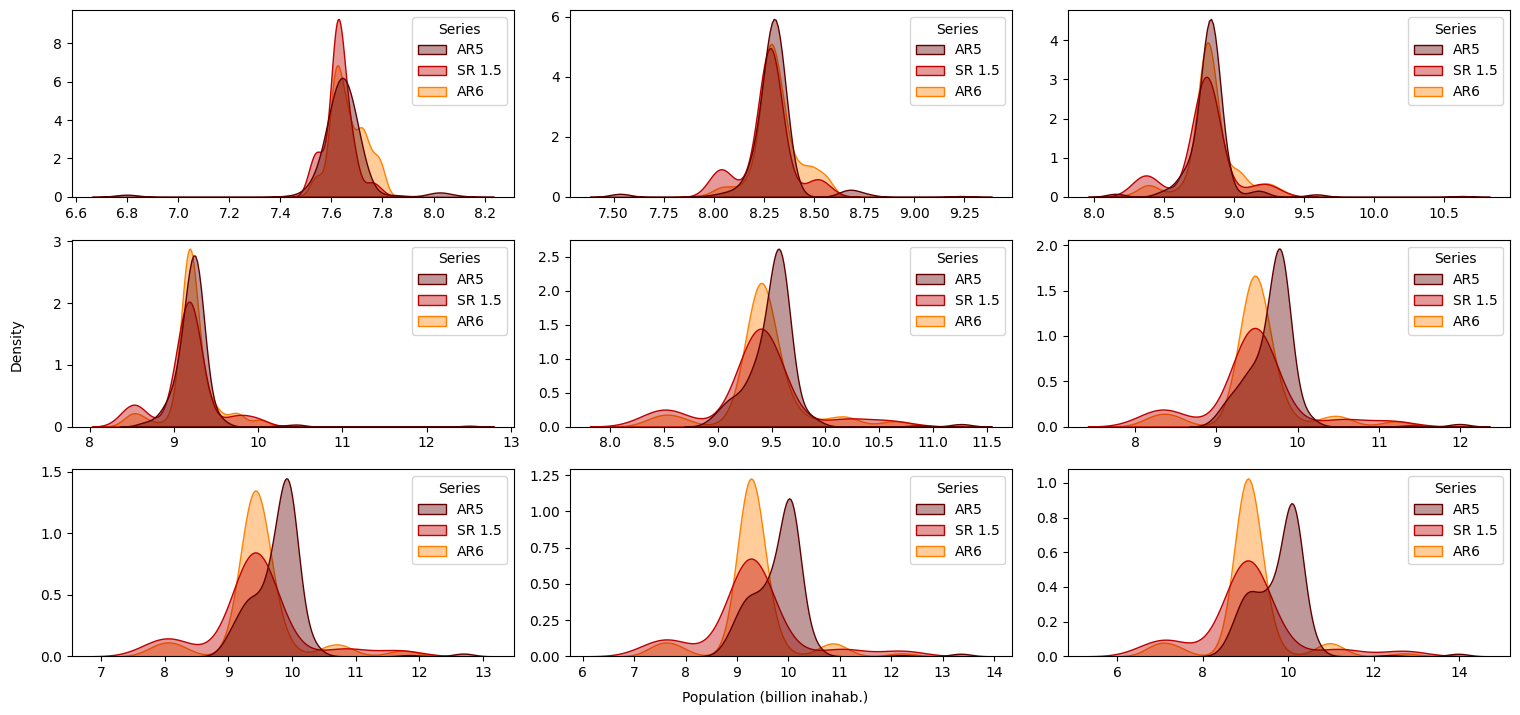

In [6]:
dataset = "AR5"
years = [2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100 ]
ar5HIt = transformAR(ar5HI, "WORLD", dataset, 20000, years)
ar5HIt["Population"] *= 1/1000

dataset = "SR 1.5"
ar15HIt = transformAR(ar15HI, "WORLD", dataset, 20000, years)
ar15HIt["Population"] *= 1/1000

dataset = "AR6"
ar6HIt = transformAR(ar6HI, "WORLD", dataset, 20000, years)
ar6HIt["Population"] *= 1/1000

data = pd.concat((pd.concat((ar5HIt, ar15HIt)), ar6HIt))


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7), sharex=False, sharey=False)
axes = axes.ravel()  # array to 1D

for year,ax in zip(years,axes):
    sns.kdeplot(data[data.Year==year], x="Population", hue="Series",fill=True, 
    palette="gist_heat", common_norm=False, bw_adjust=1.5, alpha=0.4, ax=ax)
    ax.set(xlabel=None, ylabel=None)
fig.tight_layout()
fig.text(0.5, -0.01, 'Population (billion inahab.)', ha='center')
fig.text(-0.01, 0.5, 'Density', va='center', rotation='vertical')

plt.show()




## Part 4: Figure 2.a and 2.b

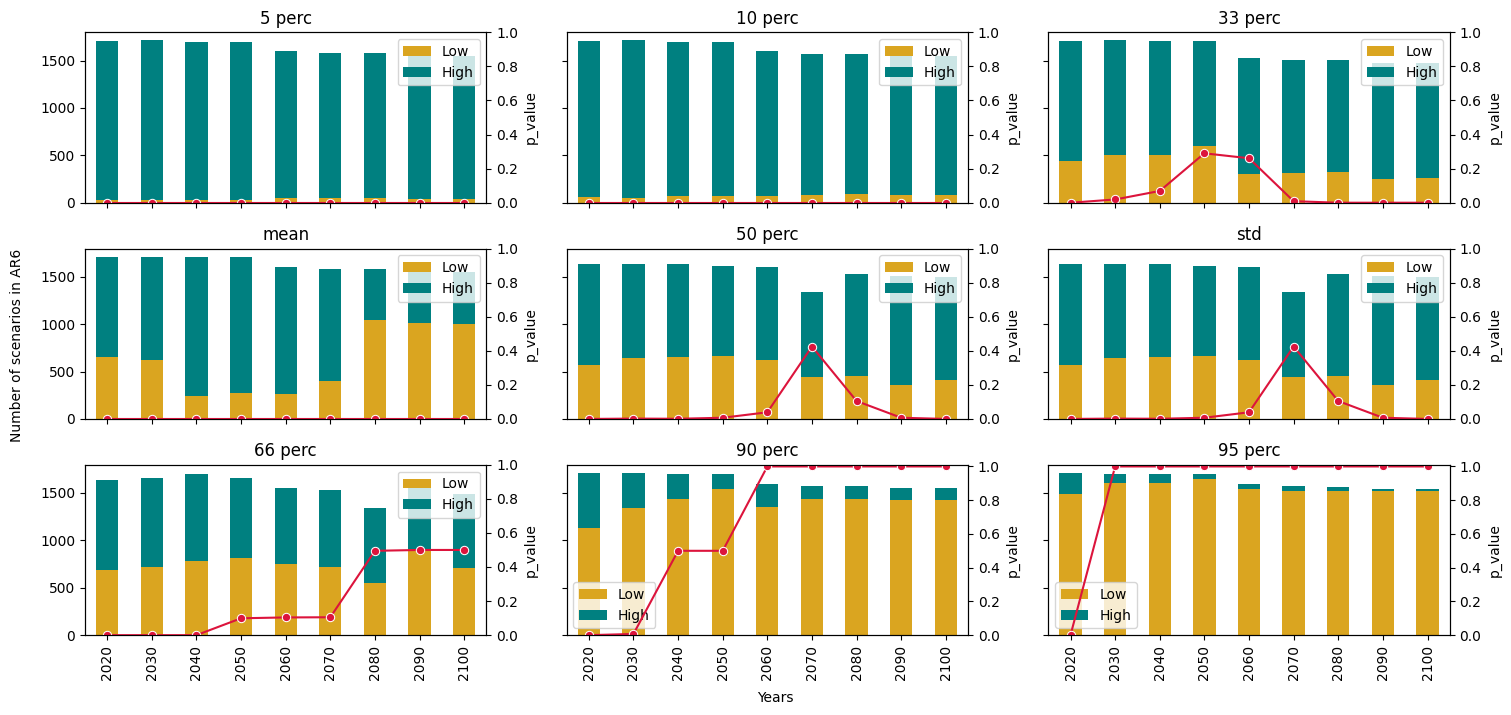

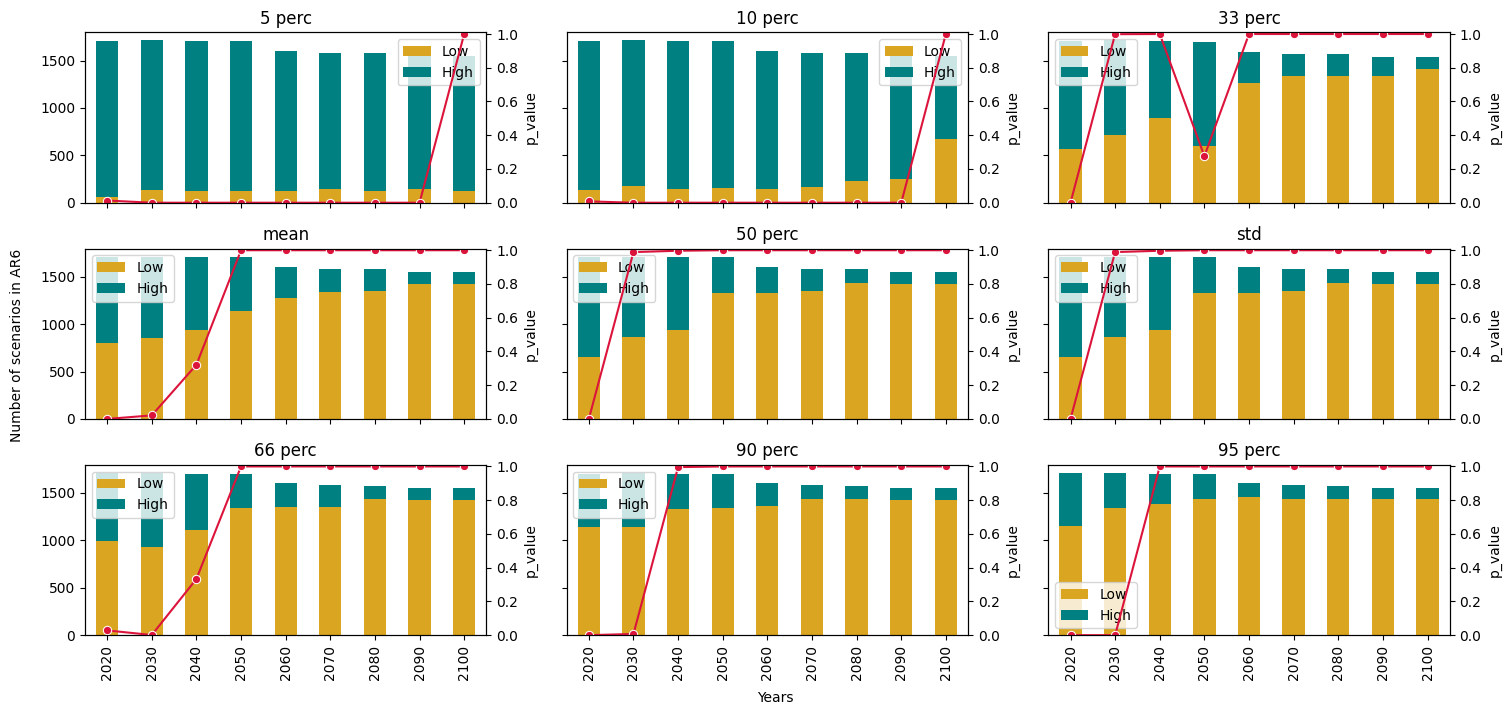

In [7]:
datablist2 = [ar15HI, ar5HI]
datablist1 = [ar6HI, ar6HI]
namelist2 = ["SR1.5", "AR5"]
namelist1 = ["AR6", "AR6"]
cutuple1 = (0.2, 0.2)
cutuple2 =[(0.05,0.05), (0.05, 0.05)]
variable = "Population"
region = "WORLD"
threshold = 5e4

for d in range(len(datablist2)):
    name2 = namelist2[d]
    name1 = namelist1[d]    
    database1 = datablist1[d]
    database2 = datablist2[d]
    data = pd.DataFrame()
    datap = databdiff(database1, name1, database2, name2, region, 
                     variable, threshold, "quantile", 0.05,  "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1])
    datap["Series"] = "5 perc"
    data = pd.concat((data, datap), axis=0)
    datap = databdiff(database1, name1, database2, name2, region,
                     variable, threshold, "quantile", 0.1,  "greater",
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1])
    datap["Series"] = "10 perc"
    data = pd.concat((data, datap), axis=0)
    datap = databdiff(database1, name1, database2, name2, region, 
                     variable, threshold, "quantile", 0.33,  "greater",
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1])                     
    datap["Series"] = "33 perc"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, region, 
                     variable, threshold, "mean",0.0,  "greater",
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1])                     
    datap["Series"] = "mean"
    data = pd.concat((data, datap), axis=0)
    datap = databdiff(database1, name1, database2, name2, region, 
                     variable, threshold, "quantile", 0.5, "greater", 
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1])                     
    datap["Series"] = "50 perc"
    data = pd.concat((data, datap), axis=0)
    datap - databdiff(database1, name1, database2, name2, region, 
                     variable, threshold, "std",0.0, "greater",
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1])                     
    datap["Series"] = "std"
    data = pd.concat((data, datap), axis=0)

    datap = databdiff(database1, name1, database2, name2, region, 
                     variable, threshold, "quantile", 0.66, "greater",
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1])                     
    datap["Series"] = "66 perc"
    data = pd.concat((data, datap), axis=0)
    datap = databdiff(database1, name1, database2, name2, region, 
                     variable, threshold, "quantile", 0.9, "greater",
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1])                     
    datap["Series"] = "90 perc"
    data = pd.concat((data, datap), axis=0)
    datap = databdiff(database1, name1, database2, name2, region, 
                     variable, threshold, "quantile", 0.95, "greater",
                     cutuple1[0], cutuple1[1], cutuple2[d][0], cutuple2[d][1])                     
    datap["Series"] = "95 perc"
    data = pd.concat((data, datap), axis=0)

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7), sharex=True, sharey=True)
    axes = axes.ravel()  # array to 1D
    series = ["5 perc", "10 perc", "33 perc", "mean", "50 perc", "std", "66 perc", "90 perc", "95 perc"]
    for ser,ax1 in zip(series,axes):
        seldata = pd.DataFrame(data[data.Series == ser])
        iter = series.index(ser)
        seldata[["Low", "High"]].plot(kind='bar', stacked=True, color=["goldenrod", "teal"], ax=ax1)
        ax1.set_title(ser)
        ax2 = ax1.twinx()
        sns.lineplot(data = seldata["p_value"], marker='o', sort = False, ax=ax2, color="crimson")
        minp = seldata["p_value"].min()

        maxp = seldata["p_value"].max() + 0.01
        maxp = max(maxp, 1)
        minp = min(0, maxp)
        ax2.set_ylim(minp, maxp)
        # labels for x & y axis

    fig.tight_layout()
    fig.text(0.5, -0.01, 'Years', ha='center')
    fig.text(-0.01, 0.5, 'Number of scenarios in AR6', va='center', rotation='vertical')


## Part 5: Figure 3

### Alternative datasets (UN, World bank, and IDB)

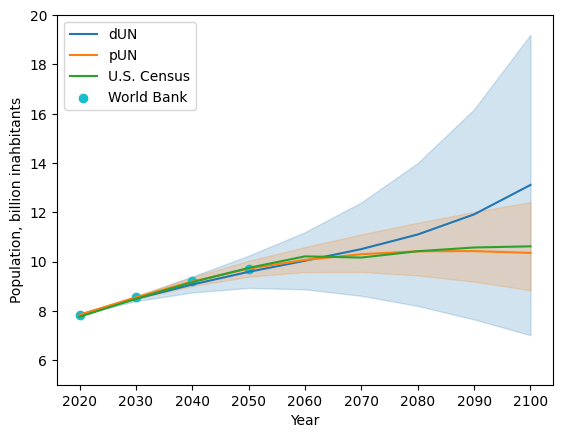

In [8]:
folder = r'data/other_pop_data'
filename1 = "uscensus.xlsx"

census = pd.read_excel(os.path.join(folder, filename1),"uscensus")
excluded = ["Annual Growth Rate %",
        	"Area (sq km)",
            "Density (per sq km)",
            "Total Fertility Rate",
            "Life Expectancy at Birth",
            "Under-5 Mortality Rate"]
included = [col for col in census.columns if col not in excluded]
census = census[included]
census = census.loc[census.Year.isin(years)]
censusg = census.groupby(["Year", "IPCCRegion"])["Population"].sum().reset_index()
censusg["Model"] = "U.S. Census"
#censusg["Type"] = "Determ"

world = census.groupby(["Year"])["Population"].sum().reset_index()
world["IPCCRegion"] = "WORLD"
world["Model"] = "U.S. Census"
#world["Type"] = "Determ"
world = world[censusg.columns]
censusg = pd.concat((censusg, world))


w2022t = transformUN(indata=w2022_1, region="WORLD", rename=True)
w2022t["Model"] = "pUN"
w2022t["IPCCRegion"] = "WORLD"
w2022t = w2022t[censusg.columns]

w2022t2,sel_labels = transformUNminmax(indata=w2022_1ext, region="WORLD", rename=True)
w2022t2 = w2022t2.loc[w2022t2.Labels.isin(sel_labels)]
w2022t2["Model"] = "dUN"
w2022t2["IPCCRegion"] = "WORLD"
w2022t2 = w2022t2[censusg.columns]

w2022t = pd.concat((w2022t2,w2022t))
w2022t["Population"] *= 1/1000


filename2 = "worldbank.xlsx"
columns = ["Country Name",
           "IPCCRegion",
           "2020 [YR2020]",
           "2030 [YR2030]",
           "2040 [YR2040]",
           "2050 [YR2050]"]
newcolumns = ["Country Name",
                "IPCCRegion",
                "2020",
                "2030",
                "2040",
                "2050"]

dtypes = [str, str, float, float, float]
wbank = pd.read_excel(os.path.join(folder, filename2),"worldbank", 
        usecols=columns)
wbank = wbank.rename(columns=dict(zip(columns,newcolumns)))
wbank = pd.DataFrame(wbank[newcolumns])
IPCCRegions = ["R5ASIA", "R5OECD90+EU", "R5OWO", "R5LAM", "R5MAF", "R5REF"]
wbank = wbank[wbank.IPCCRegion.isin(IPCCRegions)]

wbankg = pd.DataFrame()
for y in newcolumns[2:]:
        added = pd.DataFrame(wbank.groupby("IPCCRegion")[y].sum().reset_index())
        added = added.rename(columns={y:"Population"})
        added["Year"] = int(y)
        wbankg = pd.concat((wbankg,added))
wbankg = wbankg.loc[wbankg.IPCCRegion != "IPCCRegion"]
wbankg["Model"] = "WorldBank"
wbankg["Type"] = "Determ"
wbankg = wbankg[censusg.columns]
world = wbankg.groupby(["Year"])["Population"].sum().reset_index()
world["IPCCRegion"] = "WORLD"
world["Model"] = "World Bank"
world["Type"] = "Determ"
world = world[censusg.columns]
wbankg = pd.concat((wbankg, world))


censusg["Population"] = censusg["Population"]/1e9
wbankg["Population"] = wbankg["Population"]/1e9
data = pd.concat((pd.concat((w2022t, censusg)), wbankg))

regions = ["WORLD"]

for r,region in enumerate(regions):
    datar = data.loc[data.IPCCRegion == region]

    g = sns.lineplot(data=pd.DataFrame(datar.loc[datar.Model != "World Bank" ]), 
    x="Year", y="Population", hue="Model", estimator="median",  errorbar=('pi', 100))

    wadd = pd.DataFrame(datar.loc[datar.Model == "World Bank"]).rename(columns={"Population": "World Bank"})
    g.x = wadd.Year
    g.y = wadd["World Bank"]
    g.scatter(data=wadd, x="Year", y="World Bank", c='#17becf')

    plt.legend(loc="upper left")

    plt.ylabel("Population, billion inahbitants")
    plt.ylim(5,20)



### Alternative datasets (UN, RFF)

(5.0, 20.0)

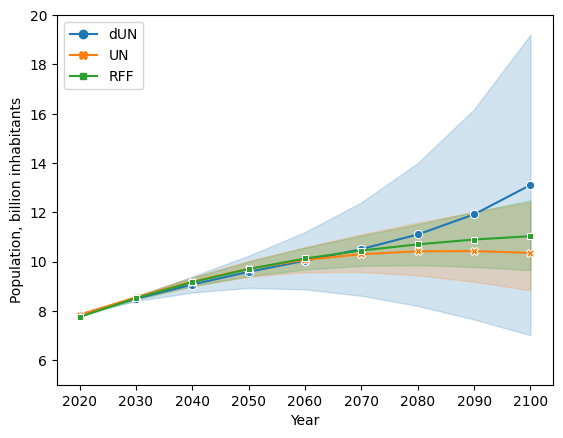

In [9]:
### Upload RFF data
folder=r'data'
all_data = pd.read_csv(os.path.join(folder,"RFF.csv"))

### Comparison between probabilistic projections RFF with UN percentiles

# Here values are transformed in billions
all_data = all_data.rename(columns={"Pop": "Population"})

years = [2020, 2030, 2040, 2050, 2060, 2070,
            2080, 2090, 2100]
quantiles = [0.05, 0.2, 0.5, 0.8, 0.95]
# selected data 
sdata = pd.concat([pd.DataFrame(all_data[["Population","year"]].loc[all_data.year==y]) for y in years])

# estimate quantiles per year and collect everything in undata
pdRFF = pd.DataFrame()
for y in years:
    pdquant = pd.concat([pd.DataFrame.quantile(pd.DataFrame(sdata[["Population"]].loc[all_data.year==y])/1e6, quantile) for quantile in quantiles] )
    pdquant=pd.concat((pdquant.reset_index(),pd.Series(np.array(quantiles)).reset_index()),axis=1)
    pdquant["Year"] = y
    pdRFF = pd.concat((pdRFF,pdquant), axis=0)
pdRFF = pdRFF.drop("index", axis=1)
pdRFF.columns = ["Population", "Series", "Year"]
pdRFF["Labels"] = pdRFF["Series"]
change = {0.05: "5 pRFF", 0.2: "20 pRFF", 0.5: "50 pRFF", 0.8: "80 pRFF", 0.95: "95 pRFF"}
for ch in change.keys():
    pdRFF["Labels"] = pdRFF["Labels"].replace(ch, change[ch])
pdRFF["Model"] = "RFF"
undata = transformUN(w2022_1, "WORLD", True)
undata["Population"] = undata["Population"]/1000
undata["Model"] = "UN"
change = {"5": "5 pUN", "20": "20 pUN", "50": "50 pUN", "80": "80 pUN", "95": "95 pUN"}
undata["Series"] = pd.Series(undata["Labels"])
undata = undata[pdRFF.columns]
for ch in change.keys():
    undata["Labels"] = undata["Labels"].replace(ch, change[ch])

change = {"5": 0.05, "20": 0.2, "50": 0.5, "80": 0.8, "95": 0.95}
for ch in change.keys():
    undata["Series"] = undata["Series"].replace(ch, change[ch])
undata=undata.sort_values(by="Series")
unRFF = pd.concat((undata, pdRFF))

### Deterministic UN vs probabilistic UN
region="WORLD"
indata, sel_labels = transformUNminmax(w2022_1ext, region, False)
indata["Population"] *=1/1000
indata["Model"]="dUN"
undata["Model"]="pUN"
undata_ext=pd.concat((indata,undata))

### Deterministic UN, probabilistic UN and RFF

undata_ext2=pd.concat((indata, unRFF))
sns.lineplot(data=undata_ext2, x=undata_ext2.Year, y= undata_ext2.Population, hue="Model", style="Model", 
estimator="median",  errorbar=("pi",100), markers=True, dashes=False)
plt.legend(loc="upper left")
plt.ylabel("Population, billion inhabitants")
plt.xlabel("Year")
plt.ylim(5, 20)

### Alternative datasets (SSPs, RFF)

(5.0, 20.0)

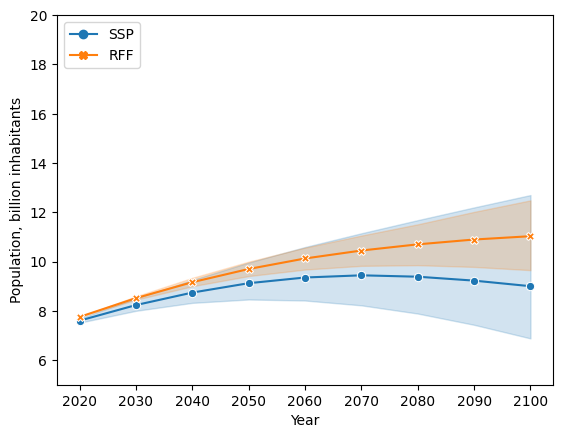

In [10]:
SSPgroups = readSSP()[2]
pdRFFchart = pdRFF.drop(["Series"], axis=1)
pdRFFchart = pdRFFchart.rename(columns={"Labels": "Scenario"})
transSSP = transformSSP(SSPgroups,"WORLD", years, "Population")
transSSP["Model"] ="SSP"
transSSP = transSSP.rename(columns={"sYear": "Year"})
transSSP["Population"] *= 1/1000
SSPRFF = pd.concat((transSSP, pdRFFchart))
SSPRFF["Year"] = pd.Series(SSPRFF["Year"], dtype=int)

sns.lineplot(data=SSPRFF, x=SSPRFF.Year, y= SSPRFF.Population, 
hue="Model",  style="Model", estimator="median",  errorbar=('pi', 100), markers=True, dashes=False)
plt.legend(loc="upper left")
plt.ylabel("Population, billion inhabitants")
plt.xlabel("Year")
plt.ylim(5, 20)

(5.0, 20.0)

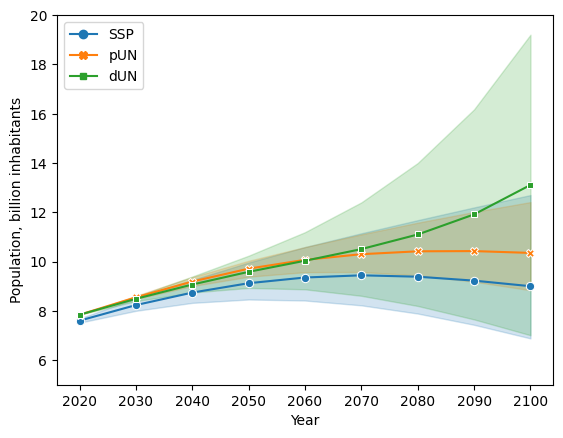

In [11]:
# UN probabilistic
undata = transformUN(w2022_1, "WORLD", True)
undata["Model"] = "pUN"
change = {"5": "5 pUN", "20": "20 pUN", "50": "50 pUN", "80": "80 pUN", "95": "95 pUN"}
undata["Series"] = undata["Labels"]
undata = undata[pdRFF.columns]
for ch in change.keys():
    undata["Labels"] = undata["Labels"].replace(ch, change[ch])

change = {"5": 0.05, "20": 0.02, "50": 0.5, "80": 0.8, "95": 0.95}
for ch in change.keys():
    undata["Series"] = undata["Series"].replace(ch, change[ch])

undata = undata.drop("Series",axis=1)
undata = undata.rename(columns={"Labels": "Scenario"})
undata["Population"] *= 1/1000

#UN extremes
undata_ext, sel_labels = transformUNminmax(w2022_1ext, "WORLD", False)
undata_ext["Model"] = "dUN"
change = {"Constant-fertility": "Constant-fertility", "Low variant": "Low variant"}
undata_ext["Series"] = undata_ext["Labels"]
undata_ext = undata_ext[pdRFF.columns]
for ch in change.keys():
    undata_ext["Labels"] = undata_ext["Labels"].replace(ch, change[ch])

change = {"Constant-fertility": 1, "Low variant": 0.01}
for ch in change.keys():
    undata_ext["Series"] = undata_ext["Series"].replace(ch, change[ch])

undata_ext = undata_ext.drop("Series",axis=1)
undata_ext = undata_ext.rename(columns={"Labels": "Scenario"})
undata_ext["Population"] *= 1/1000


transSSP = transformSSP(SSPgroups,"WORLD", years, "Population")
transSSP = transSSP.rename(columns={"sYear": "Year"})
transSSP["Population"] *= 1/1000
transSSP["Model"] = "SSP"

SSPUN= pd.concat((pd.concat((transSSP,undata)),undata_ext))
SSPUN["Year"] = pd.Series(SSPUN["Year"], dtype=int)

sns.lineplot(data=SSPUN, x=SSPUN.Year, y= SSPUN.Population, hue="Model",  style="Model" , estimator="median", errorbar=("pi", 100), markers=True, dashes=False)
plt.legend(loc="upper left")
plt.ylabel("Population, billion inhabitants")
plt.xlabel("Year")
plt.ylim(5, 20)

## Part 6: Figure 4

### ARs and UN (probabilistic and extreme deterministic scenarios)

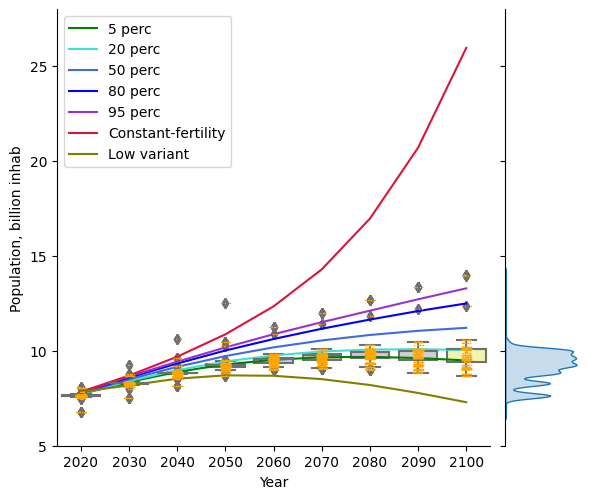

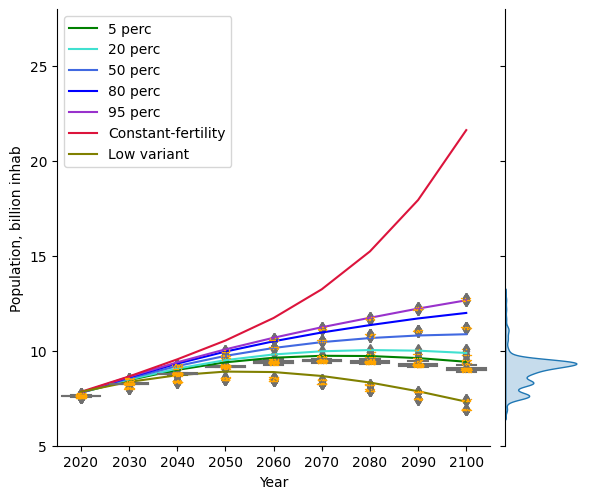

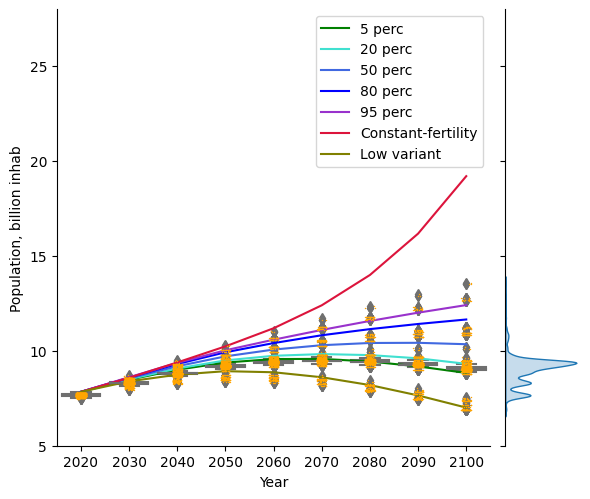

In [12]:
scaler=1/1000

dataset = "AR5"
region = "WORLD"
threshold = 1000000*scaler
limit = 28000*scaler
undata = transformUN(w2015_1, region, True)
undata["Population"] *=1/1000
ar5HImod = ar5HI.copy(deep=True)
ar5HImod.loc[ar5HImod.Variable=="Population", ar5HImod.columns[6:]] *= 1/1000
indata, sel_labels = transformUNminmax(w2015_1ext, region, False)
indata["Population"] *=1/1000
undata=pd.concat((undata,indata))
joinplot4(ar5HImod, region, threshold, undata, dataset, years, limit, sel_labels)

dataset = "SR1.5"
region = "WORLD"
threshold = 1000000*scaler
limit = 28000*scaler
undata = transformUN(w2019_1, region, True)
undata["Population"] *=1/1000
ar15HImod = ar15HI.copy(deep=True)
ar15HImod.loc[ar15HImod.Variable=="Population", ar15HImod.columns[6:]] *= 1/1000
indata, sel_labels = transformUNminmax(w2019_1ext, region, False)
indata["Population"] *=1/1000
undata=pd.concat((undata,indata))
joinplot4(ar15HImod, region, threshold, undata, dataset, years, limit, sel_labels)

dataset = "AR6"
region = "WORLD"
threshold = 1000000*scaler
limit = 28000*scaler
undata = transformUN(w2022_1, region, True)
undata["Population"] *=1/1000
ar6HImod = ar6HI.copy(deep=True)
ar6HImod.loc[ar6HImod.Variable=="Population", ar6HImod.columns[6:]] *= 1/1000
indata, sel_labels = transformUNminmax(w2022_1ext, region, False)
indata["Population"] *=1/1000
undata=pd.concat((undata,indata))
joinplot4(ar6HImod, region, threshold, undata, dataset, years, limit, sel_labels)

### ARs and SSPs

<Figure size 640x480 with 0 Axes>

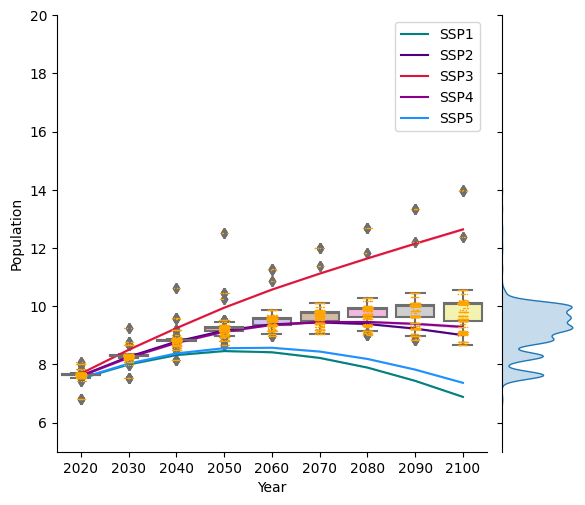

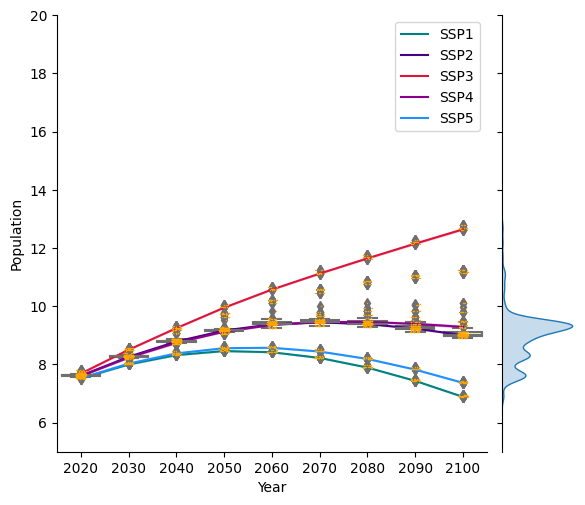

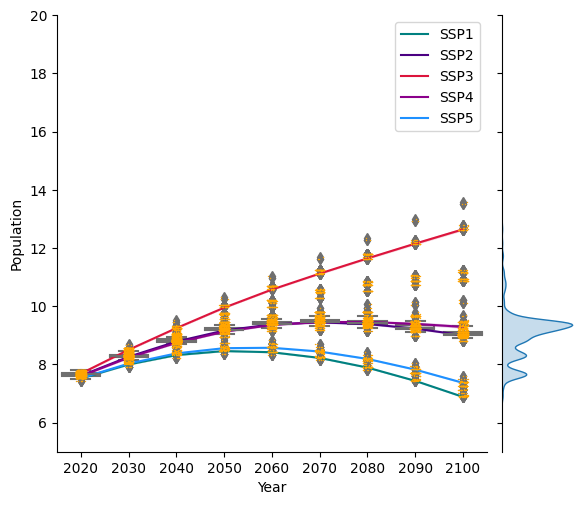

In [13]:
plt.figure(2)
joinplot3b(ar5HImod, "WORLD", [0,1, 1000], SSPgroups, 1000, "AR5", years, False, (5,20))
joinplot3b(ar15HImod, "WORLD",  [0,1, 1000],SSPgroups, 1000, "SR1.5", years, False,(5,20))
joinplot3b(ar6HImod, "WORLD",  [0,1, 1000], SSPgroups, 1000, "AR6", years, False,  (5,20))

## Part 7: Figure 5
Illustrative mitigation Pathways (IPs) and SSPs

(5.0, 15.0)

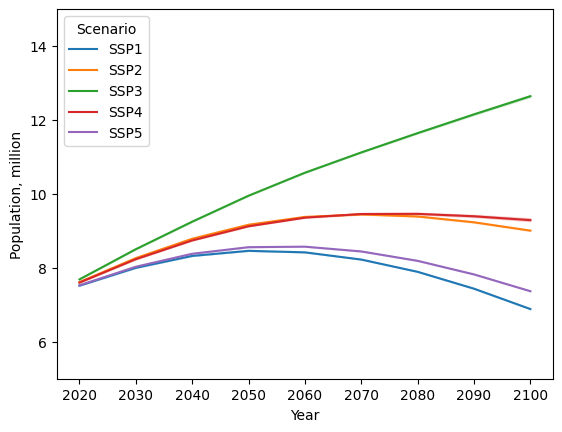

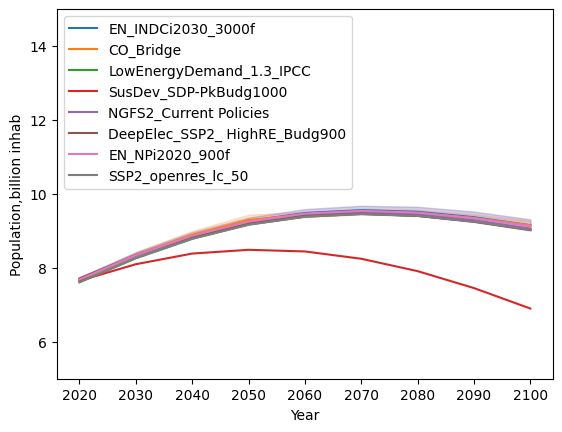

In [14]:
# represent SSP population
plt.figure(1)
SSPgroups = readSSP()[2]
sspdata=transformSSP(SSPgroups,"WORLD", years, "Population")
sspdata["Population"] *= 1/1000 
sns.lineplot(sspdata, y="Population", x="sYear", hue="Scenario", errorbar=('ci', 95), legend=True)
plt.xlabel("Year")
plt.ylabel("Population, million")
plt.ylim(5,15)


plt.figure(2)
ar6emi = pd.DataFrame(ar6HI.loc[ar6HI.Variable == 'Population'])
plotyear = ["2020","2030" ,"2040", "2050", "2060", "2070", "2080", "2090", "2100"]
scenarios= list(set(ar6emi.Scenario))
imp_list = ["EN_NPi2020_400f_lowBECCS", "EN_NPi2020_900f", "NGFS2_Current Policies", "EN_INDCi2030_3000f", "LowEnergyDemand_1.3_IPCC", "SSP2_openres_lc_50",
"DeepElec_SSP2_ HighRE_Budg900", "SusDev_SDP-PkBudg1000", "CO_Bridge"]
scenarios = [m for m in scenarios if m in imp_list]
ar6emitm = pd.DataFrame() # ar6emi transpose: columns emissions and year
for y in plotyear:
    new = pd.DataFrame()
    for ms in scenarios:
        ar6emiscm = ar6emi.loc[ar6emi.Scenario==ms]
        data = ar6emiscm[y]

        data = np.array(data)/1000
        nnew = pd.DataFrame(data, columns=["Population"]).fillna(method='backfill')
        nnew["Scenario"] = ms

        new = pd.concat((new,nnew))

    new["Year"] = int(y)
    ar6emitm = pd.concat((ar6emitm,new))
    
sns.lineplot(ar6emitm, y="Population", x="Year", hue="Scenario")
plt.xlabel("Year")
plt.ylabel("Population,billion inhab")
plt.legend(loc='upper left')
plt.ylim(5,15)

## Part 8: Figures 7-10

First display scenario trends, then weightin RFF, then weighting UN probabilistic scenarios


(5.0, 20.0)

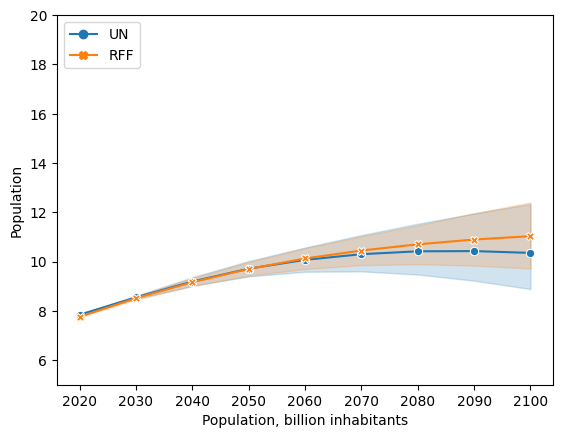

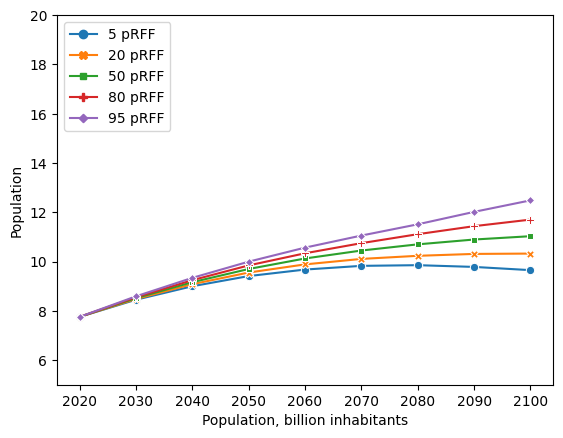

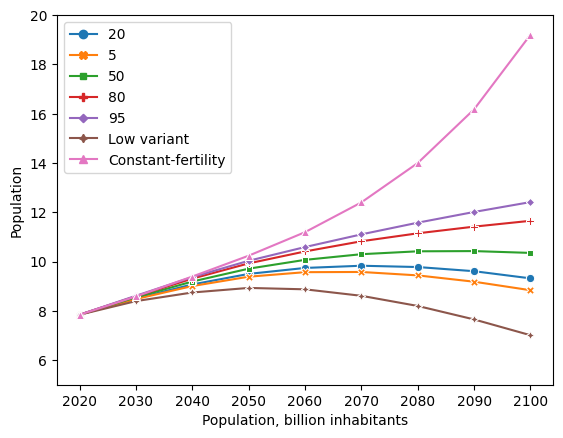

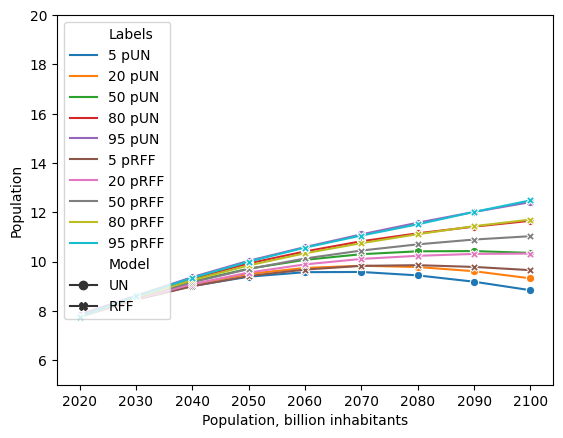

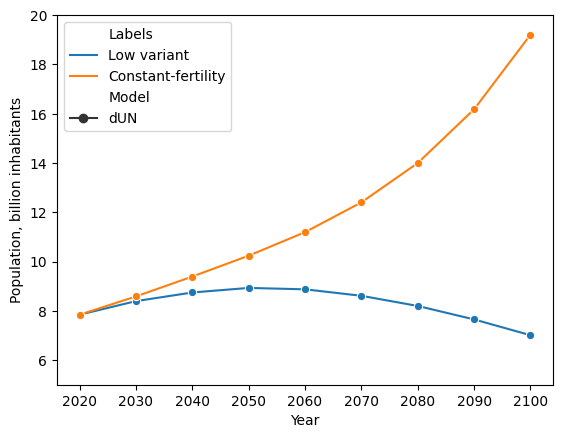

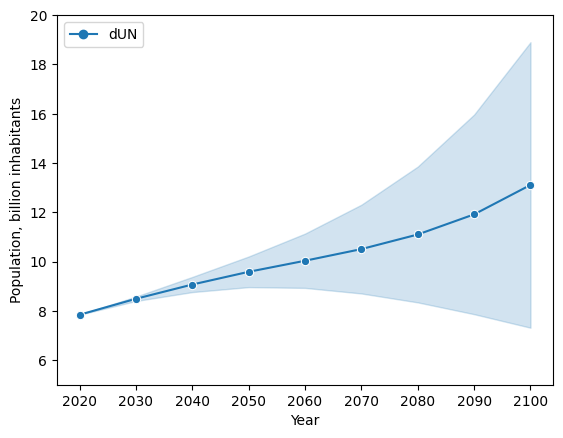

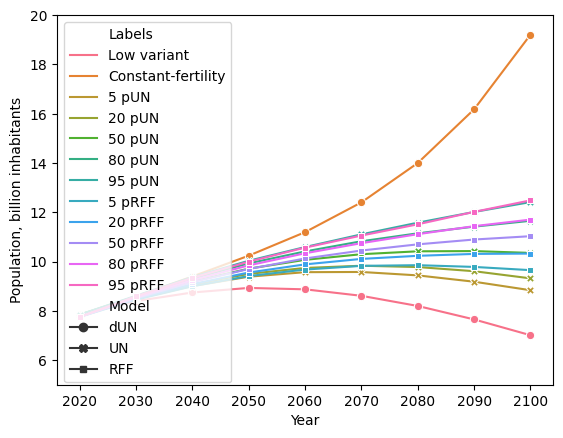

In [15]:
# Rename "Scenario" column into "Labels" for consistency with RFF dataframe
undata_ext = undata_ext.rename(columns={"Scenario": "Labels"})

plt.figure(1)
sns.lineplot(data=unRFF, x=unRFF.Year, y= unRFF.Population, hue="Model",  estimator="median", errorbar=('pi', 95), style="Model",   markers=True, dashes=False)
plt.legend(loc="upper left")
plt.xlabel("Population, billion inhabitants")
plt.ylim(5, 20)

plt.figure(2)
sns.lineplot(data=pdRFF, x=pdRFF.Year, y= pdRFF.Population, hue="Labels",  estimator="median", errorbar=('pi', 95), style="Labels",  markers=True, dashes=False)
plt.legend(loc="upper left")
plt.xlabel("Population, billion inhabitants")
plt.ylim(5, 20)

plt.figure(3)
sns.lineplot(data=undata, x=undata.Year, y= undata.Population, hue="Labels",  estimator="median", errorbar=('pi', 95), style="Labels",  markers=True, dashes=False)
plt.legend(loc="upper left")
plt.xlabel("Population, billion inhabitants")
plt.ylim(5, 20)

plt.figure(4)
sns.lineplot(data=unRFF, x=unRFF.Year, y= unRFF.Population, hue="Labels",  estimator="median", errorbar=('pi', 95), style="Model",   markers=True, dashes=False)
plt.legend(loc="upper left")
plt.xlabel("Population, billion inhabitants")
plt.ylim(5, 20)

plt.figure (5)
sns.lineplot(data=undata_ext, x=undata_ext.Year, y= undata_ext.Population, hue="Labels", style="Model",  errorbar=('pi', 95),  markers=True, dashes=False)
plt.legend(loc="upper left")
plt.ylabel("Population, billion inhabitants")
plt.xlabel("Year")
plt.ylim(5, 20)

plt.figure (6)
sns.lineplot(data=undata_ext, x=undata_ext.Year, y= undata_ext.Population, hue="Model", style="Model", 
estimator="median", errorbar=('pi', 95),  markers=True, dashes=False)
plt.legend(loc="upper left")
plt.ylabel("Population, billion inhabitants")
plt.xlabel("Year")
plt.ylim(5, 20)

plt.figure (7)
sns.lineplot(data=undata_ext2, x=undata_ext2.Year, y= undata_ext2.Population, hue="Labels", style="Model", 
estimator="median",  errorbar=("pi", 100), markers=True, dashes=False)
plt.legend(loc="upper left")
plt.ylabel("Population, billion inhabitants")
plt.xlabel("Year")
plt.ylim(5, 20)

### Weighting RFF on SSPs

RFF quantiles lie in these SSPs
95 (SSP3, SSP4)
80 (SSP3, SSP4)
50 (SSP3, SSP4)
20 (SSP3, SSP4)
5  (SSP3, SSP4)

Text(0, 0.5, 'Weighting factors, %')

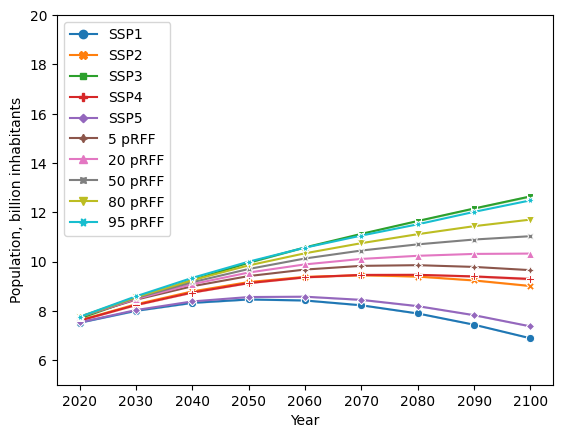

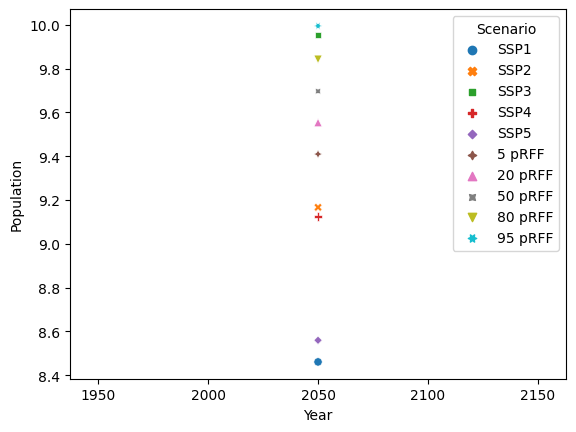

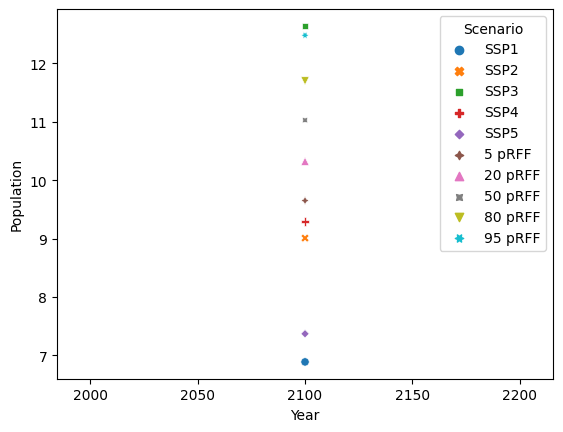

<Figure size 640x480 with 0 Axes>

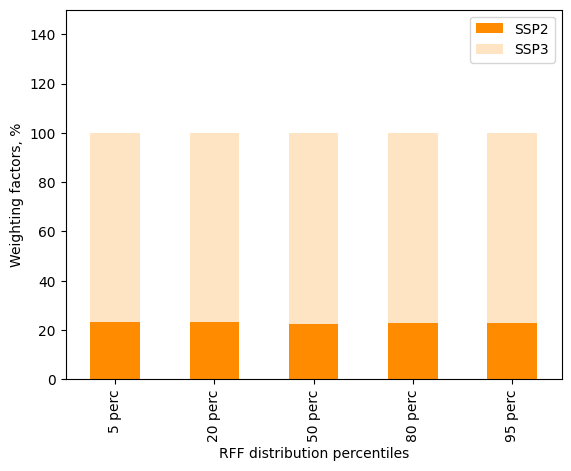

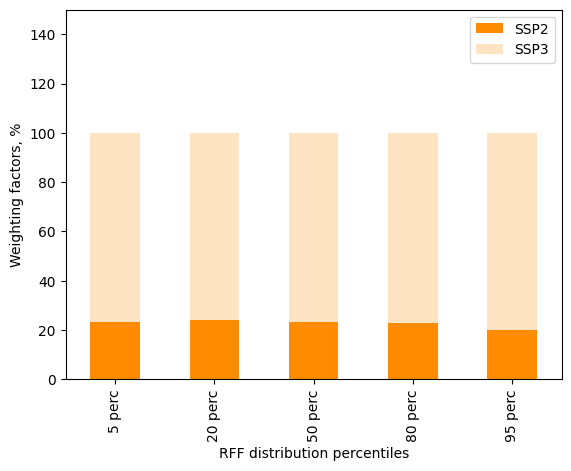

In [16]:
pdRFFchart = pdRFF.drop(["Series"], axis=1)
pdRFFchart = pdRFFchart.rename(columns={"Labels": "Scenario"})
transSSP = transformSSP(SSPgroups,"WORLD", years, "Population")
transSSP["Model"] ="SSP"
transSSP = transSSP.rename(columns={"sYear": "Year"})
transSSP["Population"] *= 1/1000
SSPRFF = pd.concat((transSSP, pdRFFchart))
SSPRFF["Year"] = pd.Series(SSPRFF["Year"], dtype=int)

plt.figure(1)
sns.lineplot(data=SSPRFF, x=SSPRFF.Year, y= SSPRFF.Population, hue="Scenario",  style="Scenario" ,  markers=True, dashes=False)
plt.legend(loc="upper left")
plt.ylabel("Population, billion inhabitants")
plt.xlabel("Year")
plt.ylim(5, 20)
# Training set represents the SSP
x_train = transformSSP(SSPgroups, "WORLD", years, "Population")
x_train["Population"] *= 1/1000
x_train = x_train.rename(columns={"sYear": "Year"})
x_train["Year"] = pd.Series(x_train["Year"],dtype=int)
group =[ "Year", "Scenario"]
X = x_train.groupby(by=group)['Population'].mean().reset_index()

plt.figure (2)
X2050 = pd.DataFrame(X.loc[X.Year==2050])
X2050["Model"] = "SSP"
pdRFF2050 = pdRFF.loc[pdRFF.Year==2050].drop(["Series"], axis=1).rename(columns={"Labels": "Scenario"})

data2050 = pd.concat((X2050,pdRFF2050), axis=0)

sns.scatterplot(data2050, x=data2050.Year, y=data2050.Population, hue="Scenario", style="Scenario")


X2100 = pd.DataFrame(X.loc[X.Year==2100])
X2100["Model"] = "SSP"
pdRFF2100 = pdRFF.loc[pdRFF.Year==2100].drop(["Series"], axis=1).rename(columns={"Labels": "Scenario"})

data2100 = pd.concat((X2100,pdRFF2100), axis=0)
plt.figure (3)
sns.scatterplot(data2100, x=data2100.Year, y=data2100.Population, hue="Scenario", style="Scenario")


# Use minimize function
# Relevant scenarios from RFF study belong to the subset SSP3, SSP4

import scipy.optimize as opt

selected_scenarios = ["SSP2", "SSP3"]
nsample = len(selected_scenarios)

X = X[X["Scenario"].isin(selected_scenarios)]

def f2020(x: np.array):
    xi = np.array(X.loc[(X.Year==2020)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2020) & (pdRFF.Labels==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2030(x: np.array):
    xi = np.array(X.loc[(X.Year==2030)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2030) & (pdRFF.Labels==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2040(x: np.array):
    xi = np.array(X.loc[(X.Year==2040)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2040) & (pdRFF.Labels==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2050(x: np.array):
    xi = np.array(X.loc[(X.Year==2050)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2050) & (pdRFF.Labels==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2060(x: np.array):
    xi = np.array(X.loc[(X.Year==2060)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2060) & (pdRFF.Labels==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2070(x: np.array):
    xi = np.array(X.loc[(X.Year==2070)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2070) & (pdRFF.Labels==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2080(x: np.array):
    xi = np.array(X.loc[(X.Year==2080)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2080) & (pdRFF.Labels==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2090(x: np.array):
    xi = np.array(X.loc[(X.Year==2090)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2090) & (pdRFF.Labels==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2100(x: np.array):
    xi = np.array(X.loc[(X.Year==2100)]["Population"])
    y = np.array(pdRFF.loc[(pdRFF.Year==2100) & (pdRFF.Labels==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

bounds=[(0.01,1), (0.01,1)]
scenarios = np.array(selected_scenarios).reshape(-1,1)
reslabel = pd.DataFrame()

pdRFFlabels = ["5 pRFF", "20 pRFF", "50 pRFF", "80 pRFF", "95 pRFF"]
for label in pdRFFlabels:
    res2020 = opt.minimize(f2020, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2030 = opt.minimize(f2030, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2040 = opt.minimize(f2040, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2050 = opt.minimize(f2050, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2060 = opt.minimize(f2060, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2070 = opt.minimize(f2070, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2080 = opt.minimize(f2080, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2090 = opt.minimize(f2090, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2100 = opt.minimize(f2100, x0=np.repeat(np.array(0.1), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    data2020 = res2020.x.reshape(1,-1)
    data2030 = res2030.x.reshape(1,-1)
    data2040 = res2040.x.reshape(1,-1)
    data2050 = res2050.x.reshape(1,-1)
    data2060 = res2060.x.reshape(1,-1)
    data2070 = res2070.x.reshape(1,-1)
    data2080 = res2080.x.reshape(1,-1)
    data2090 = res2090.x.reshape(1,-1)
    data2100 = res2100.x.reshape(1,-1)
    resall = np.concatenate((data2020, data2030, data2040, data2050, data2060, data2070, data2080, data2090, data2100), axis=0)
    resallframe = pd.DataFrame(data=resall, columns=np.array(["SSP2", "SSP3"]).reshape(-1,1), index=np.repeat([label], 9))
    resallframe["Year"] = years
    reslabel = pd.concat((reslabel,resallframe), axis=0)
reslabel = reslabel.reset_index()
reslabel.columns = ["Scenario", "SSP2", "SSP3", "Year"]
selected_years = [2050]
data = reslabel[reslabel.Year.isin(selected_years)]

plt.figure (4)
chart  = pd.DataFrame()
for s, scenario in enumerate(pdRFFlabels):
    for y in selected_years:
        datas = pd.DataFrame(data.loc[(data.Scenario == scenario) & (data.Year==y)])
        datas["SSP2"] = pd.Series(datas["SSP2"] * 100)
        datas["SSP3"] = pd.Series(datas["SSP3"] * 100)
        chart = pd.concat((chart,datas))
        chart = chart.drop("Year", axis=1)
chart["sum"] =  chart["SSP2"] + chart["SSP3"]
chart["SSP2"] *= 100/chart["sum"]
chart["SSP3"] *= 100/chart["sum"]
chart=chart.drop("sum", axis=1)
colours = ["darkorange", "bisque",
            "salmon", "mistyrose",
            "olivedrab", "darkseagreen",
            "cadetblue", "lightcyan",
            "slategrey", "lightsteelblue" ]
chart.plot(kind="bar", stacked=True, color=colours )
plt.xticks(ticks=np.array([0,1,2,3,4]),
           labels=["5 perc", "20 perc", "50 perc", "80 perc",  "95 perc"])
plt.ylim(0,150)
plt.xlabel("RFF distribution percentiles")
plt.ylabel("Weighting factors, %")

plt.figure(5)
selected_years = [2100]
data = reslabel[reslabel.Year.isin(selected_years)]

chart  = pd.DataFrame()
for s, scenario in enumerate(pdRFFlabels):
    for y in selected_years:
        datas = pd.DataFrame(data.loc[(data.Scenario == scenario) & (data.Year==y)])
        datas["SSP2"] = pd.Series(datas["SSP2"] * 100)
        datas["SSP3"] = pd.Series(datas["SSP3"] * 100)
        chart = pd.concat((chart,datas))
        chart = chart.drop("Year", axis=1)
chart["sum"] =  chart["SSP2"] + chart["SSP3"]
chart["SSP2"] *= 100/chart["sum"]
chart["SSP3"] *= 100/chart["sum"]
chart=chart.drop("sum", axis=1)
colours = ["darkorange", "bisque",
            "salmon", "mistyrose",
            "olivedrab", "darkseagreen",
            "cadetblue", "lightcyan",
            "slategrey", "lightsteelblue" ]
chart.plot(kind="bar", stacked=True, color=colours )
plt.xticks(ticks=np.array([0,1,2,3,4]),
           labels=["5 perc", "20 perc", "50 perc", "80 perc",  "95 perc"])
plt.ylim(0, 150)
plt.xlabel("RFF distribution percentiles")
plt.ylabel("Weighting factors, %")

### Weighting UN on SSPs

(5.0, 20.0)

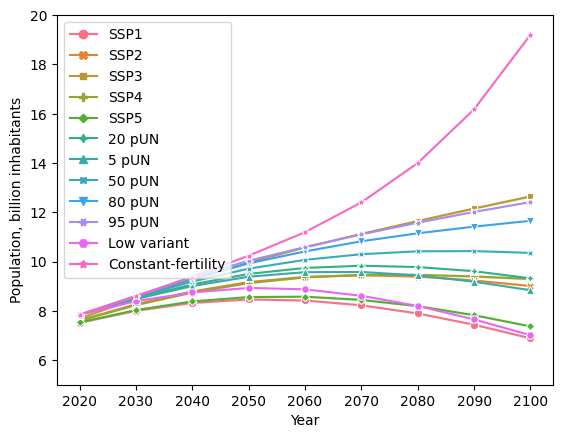

In [17]:
# UN probabilistic
undata = transformUN(w2022_1, "WORLD", True)
undata["Model"] = "pUN"
change = {"5": "5 pUN", "20": "20 pUN", "50": "50 pUN", "80": "80 pUN", "95": "95 pUN"}
undata["Series"] = undata["Labels"]
undata = undata[pdRFF.columns]
for ch in change.keys():
    undata["Labels"] = undata["Labels"].replace(ch, change[ch])

change = {"5": 0.05, "20": 0.02, "50": 0.5, "80": 0.8, "95": 0.95}
for ch in change.keys():
    undata["Series"] = undata["Series"].replace(ch, change[ch])

undata = undata.drop("Series",axis=1)
undata = undata.rename(columns={"Labels": "Scenario"})
undata["Population"] *= 1/1000

#UN extremes
undata_ext, sel_labels = transformUNminmax(w2022_1ext, "WORLD", False)
undata_ext["Model"] = "dUN"
change = {"Constant-fertility": "Constant-fertility", "Low variant": "Low variant"}
undata_ext["Series"] = undata_ext["Labels"]
undata_ext = undata_ext[pdRFF.columns]
for ch in change.keys():
    undata_ext["Labels"] = undata_ext["Labels"].replace(ch, change[ch])

change = {"Constant-fertility": 1, "Low variant": 0.01}
for ch in change.keys():
    undata_ext["Series"] = undata_ext["Series"].replace(ch, change[ch])

undata_ext = undata_ext.drop("Series",axis=1)
undata_ext = undata_ext.rename(columns={"Labels": "Scenario"})
undata_ext["Population"] *= 1/1000


transSSP = transformSSP(SSPgroups,"WORLD", years, "Population")
transSSP = transSSP.rename(columns={"sYear": "Year"})
transSSP["Population"] *= 1/1000
transSSP["Model"] = "SSP"

SSPUN= pd.concat((pd.concat((transSSP,undata)),undata_ext))
SSPUN["Year"] = pd.Series(SSPUN["Year"], dtype=int)
sns.lineplot(data=SSPUN, x=SSPUN.Year, y= SSPUN.Population, hue="Scenario",  style="Scenario" ,  markers=True, dashes=False)
plt.legend(loc="upper left")
plt.ylabel("Population, billion inhabitants")
plt.xlabel("Year")
plt.ylim(5, 20)

Index(['index', ('SSP1',), ('SSP2',), ('SSP3',), 'Year'], dtype='object')


Text(0, 0.5, 'Weighting factors, %')

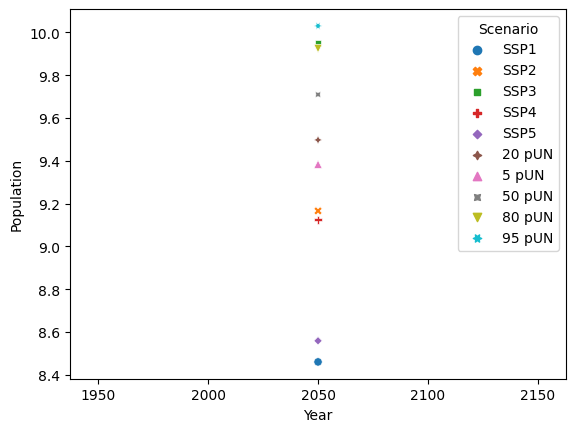

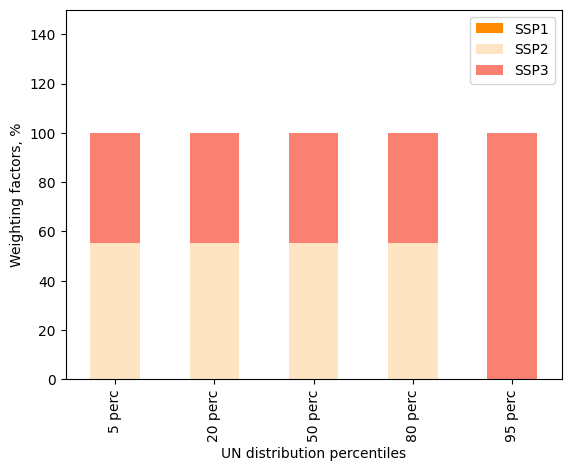

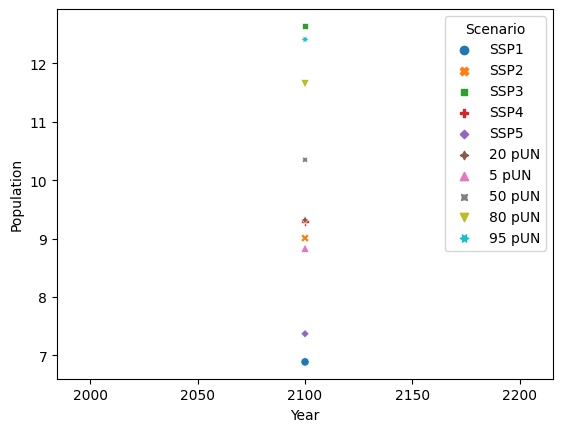

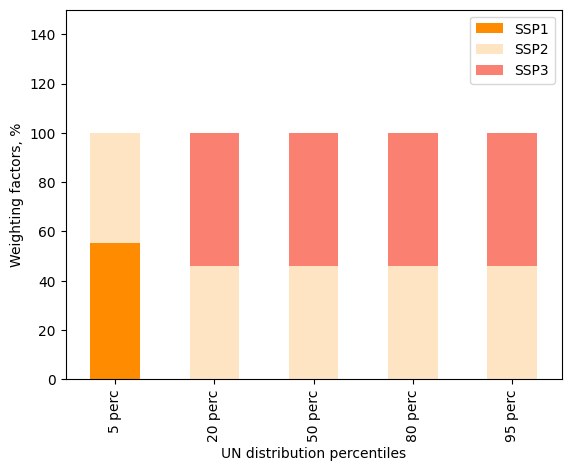

In [18]:

## 2050
undata2100 = pd.DataFrame(undata.loc[undata.Year==2050])
x_train = transformSSP(SSPgroups, "WORLD", years, "Population")
x_train["Population"] *= 1/1000
x_train = x_train.rename(columns={"sYear": "Year"})
x_train["Year"] = pd.Series(x_train["Year"],dtype=int)
group =[ "Year", "Scenario"]
X = x_train.groupby(by=group)['Population'].mean().reset_index()
X2100 = pd.DataFrame(X.loc[X.Year==2050])
X2100["Model"] = "SSP"

plt.figure(1)
databis2100 = pd.concat((X2100,undata2100), axis=0)
sns.scatterplot(databis2100, x=databis2100.Year, y=databis2100.Population, hue="Scenario", style="Scenario")

databis2100 = databis2100.sort_values("Population")

## 2100
undata2100 = pd.DataFrame(undata.loc[undata.Year==2100])
x_train = transformSSP(SSPgroups, "WORLD", years, "Population")
x_train["Population"] *= 1/1000
x_train = x_train.rename(columns={"sYear": "Year"})
x_train["Year"] = pd.Series(x_train["Year"],dtype=int)
group =[ "Year", "Scenario"]
X = x_train.groupby(by=group)['Population'].mean().reset_index()
X2100 = pd.DataFrame(X.loc[X.Year==2100])
X2100["Model"] = "SSP"
plt.figure(2)
databis2100 = pd.concat((X2100,undata2100), axis=0)
sns.scatterplot(databis2100, x=databis2100.Year, y=databis2100.Population, hue="Scenario", style="Scenario")
databis2100 = databis2100.sort_values("Population")


# Use minimize function
# Relevant scenarios from RFF study belong to the subset SSP3, SSP4

import scipy.optimize as opt

sdict = {
"5 pUN": ["SSP1", "SSP2", "SSP3"],
"20 pUN": ["SSP1", "SSP2", "SSP3"],
"50 pUN": ["SSP1", "SSP2", "SSP3"],
"80 pUN": ["SSP1", "SSP2", "SSP3"],
"95 pUN": ["SSP1", "SSP2", "SSP3"],}

bdict = {
"5 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"20 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"50 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"80 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"95 pUN": [(0.0,0.0),(0.0,0.0), (0.0,3)],
}

bdict2 = {
"5 pUN": [(0.0,1), (0.0,1), (0.0, 0.0)],
"20 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"50 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"80 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
"95 pUN": [(0.0,0.0),(0.0,1), (0.0,1)],
}


def f2020(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2020)]["Population"])
    y = np.array(undata.loc[(undata.Year==2020) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2030(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2030)]["Population"])
    y = np.array(undata.loc[(undata.Year==2030) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2040(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2040)]["Population"])
    y = np.array(undata.loc[(undata.Year==2040) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2050(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2050)]["Population"])
    y = np.array(undata.loc[(undata.Year==2050) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2060(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2060)]["Population"])
    y = np.array(undata.loc[(undata.Year==2060) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2070(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2070)]["Population"])
    y = np.array(undata.loc[(undata.Year==2070) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2080(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2080)]["Population"])
    y = np.array(undata.loc[(undata.Year==2080) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2090(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2090)]["Population"])
    y = np.array(undata.loc[(undata.Year==2090) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)

def f2100(x: np.array):
    xi = np.array(Xsel.loc[(Xsel.Year==2100)]["Population"])
    y = np.array(undata.loc[(undata.Year==2100) & (undata.Scenario==label)]["Population"])
    return np.power((np.dot(x,xi) - y), 2)


reslabel = pd.DataFrame()

UNlabels = ["5 pUN", "20 pUN", "50 pUN", "80 pUN", "95 pUN"]
for label in UNlabels:
    selected_scenarios = sdict[label]
    Xsel = X[X["Scenario"].isin(selected_scenarios)]
    nsample = len(selected_scenarios)
    bounds = bdict[label]
    bounds2 = bdict2[label]

    bounds = bdict[label]
    bounds2 = bdict2[label]
    res2020 = opt.minimize(f2020, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2030 = opt.minimize(f2030, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2040 = opt.minimize(f2040, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2050 = opt.minimize(f2050, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2060 = opt.minimize(f2060, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2070 = opt.minimize(f2070, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2080 = opt.minimize(f2080, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2090 = opt.minimize(f2090, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds)
    res2100 = opt.minimize(f2100, x0=np.repeat(np.array(0.0), repeats=nsample), method='Nelder-Mead', tol=1e-6, bounds=bounds2)
    data2020 = res2020.x.reshape(1,-1)
    data2030 = res2030.x.reshape(1,-1)
    data2040 = res2040.x.reshape(1,-1)
    data2050 = res2050.x.reshape(1,-1)
    data2060 = res2060.x.reshape(1,-1)
    data2070 = res2070.x.reshape(1,-1)
    data2080 = res2080.x.reshape(1,-1)
    data2090 = res2090.x.reshape(1,-1)
    data2100 = res2100.x.reshape(1,-1)
    resall = np.concatenate((data2020, data2030, data2040, data2050, data2060, data2070, data2080, data2090, data2100), axis=0)
    resallframe = pd.DataFrame(data=resall, columns=np.array(selected_scenarios).reshape(-1,1), index=np.repeat([label], 9))
    resallframe["Year"] = years
    reslabel = pd.concat((reslabel,resallframe), axis=0)
reslabel = reslabel.reset_index()
print (reslabel.columns)
reslabel = reslabel.rename(columns={reslabel.columns[0]: "Scenario",reslabel.columns[1]: "SSP1", reslabel.columns[2]:"SSP2", 
    reslabel.columns[3]:"SSP3"})
reslabel = reslabel.fillna(0)
reslabel = reslabel[["Scenario", "Year",  "SSP1", "SSP2", "SSP3"]]

selected_years = [2050]
data = reslabel[reslabel.Year.isin(selected_years)]
plt.figure (1)
chart  = pd.DataFrame()
for s, scenario in enumerate(UNlabels):
    for y in selected_years:
        datas = pd.DataFrame(data.loc[(data.Scenario == scenario) & (data.Year==y)])
        datas["SSP1"] = pd.Series(datas["SSP1"] * 100)
        datas["SSP2"] = pd.Series(datas["SSP2"] * 100)
        datas["SSP3"] = pd.Series(datas["SSP3"] * 100)
        chart = pd.concat((chart,datas))
        chart = chart.drop("Year", axis=1)
chart["sum"] =  chart["SSP1"] + chart["SSP2"] + chart["SSP3"]
chart["SSP1"] *= 100/chart["sum"]
chart["SSP2"] *= 100/chart["sum"]
chart["SSP3"] *= 100/chart["sum"]
chart=chart.drop("sum", axis=1)
colours = ["darkorange", "bisque",
            "salmon", "mistyrose",
            "olivedrab", "darkseagreen",
            "cadetblue", "lightcyan",
            "slategrey", "lightsteelblue" ]
chart.plot(kind="bar", stacked=True, color=colours )
plt.xticks(ticks=np.array([0,1,2,3,4]),
           labels=["5 perc", "20 perc", "50 perc", "80 perc",  "95 perc"])
plt.ylim(0,150)
plt.xlabel("UN distribution percentiles")
plt.ylabel("Weighting factors, %")

plt.figure(2)
selected_years = [2100]
data = reslabel[reslabel.Year.isin(selected_years)]

chart  = pd.DataFrame()
for s, scenario in enumerate(UNlabels):
    for y in selected_years:
        datas = pd.DataFrame(data.loc[(data.Scenario == scenario) & (data.Year==y)])
        datas["SSP1"] = pd.Series(datas["SSP1"] * 100)
        datas["SSP2"] = pd.Series(datas["SSP2"] * 100)
        datas["SSP3"] = pd.Series(datas["SSP3"] * 100)
        chart = pd.concat((chart,datas))
        chart = chart.drop("Year", axis=1)
chart["sum"] =  chart["SSP1"] + chart["SSP2"] + chart["SSP3"]
chart["SSP1"] *= 100/chart["sum"]
chart["SSP2"] *= 100/chart["sum"]
chart["SSP3"] *= 100/chart["sum"]
chart=chart.drop("sum", axis=1)

colours = ["darkorange", "bisque",
            "salmon", "mistyrose",
            "olivedrab", "darkseagreen",
            "cadetblue", "lightcyan",
            "slategrey", "lightsteelblue" ]
chart.plot(kind="bar", stacked=True, color=colours )
plt.xticks(ticks=np.array([0,1,2,3,4]),
           labels=["5 perc", "20 perc", "50 perc", "80 perc",  "95 perc"])
plt.ylim(0, 150)
plt.xlabel("UN distribution percentiles")
plt.ylabel("Weighting factors, %")

## Part 10: Figures 6 and 11-13

Regional deviations:

- Calculation made for 2020 for AR5, SR 1.5, and AR6 for 5 regions

- Calculation made for 2020 for AR6 10 regions

Text(0.5, 0, 'IPCC Region')

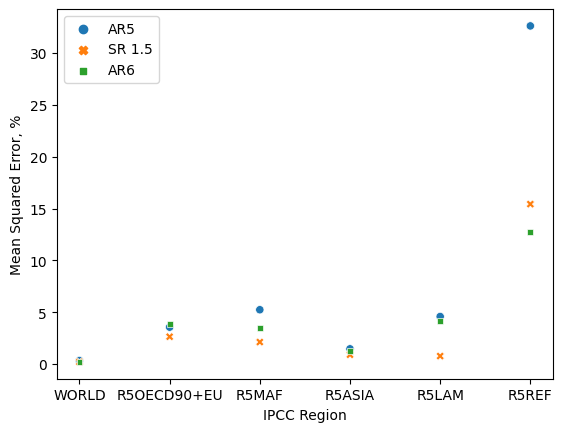

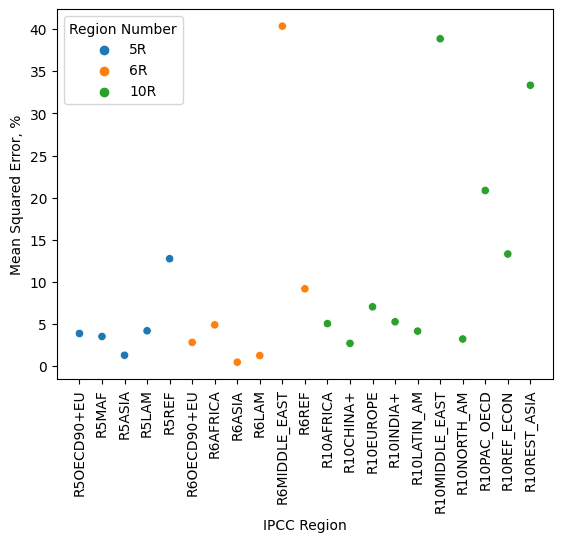

In [19]:
# world
samples = [ar5HI, ar15HI, ar6HI]
datasets = ["AR5", "SR 1.5", "AR6"]
un_databases = [w2022_5, w2015_5, w2019_5]
region = "WORLD"
year = 2020
threshold = 1000000
output = pd.DataFrame()
for s, sample in enumerate(samples):
    dataset = datasets[s]
    err = np.array(data_error(un_databases[s], sample, year, threshold, region, dataset))
    err = err.reshape(1, len(err))
    pderr = pd.DataFrame(err, columns=["MAE", "MSE", "sRMSE"], index=[dataset])
    pderr["IPCCRegion"] = region
    output = pd.concat((output, pderr), axis=0)

outputworld = output.copy(deep=True)
pad = pd.DataFrame(outputworld["sRMSE"].values.reshape(-1,1).transpose(),columns=np.array(["AR5", "SR 1.5", "AR6"]), index=["WORLD"])

# 5 regions
samples = [ar5HI, ar15HI, ar6reg5HI]
datasets = ["AR5", "SR 1.5", "AR6"]
un_databases = [r2015_5, r2019_5, r2022_5]
regions = ['R5OECD90+EU', 'R5MAF', 'R5ASIA', 'R5LAM', 'R5REF']
year = 2020
threshold = 10000
output = pd.DataFrame()
for region in regions:
    newc = pd.DataFrame()
    for s, sample in enumerate(samples):
        dataset = datasets[s]
        err = np.array(data_error(un_databases[s], sample, year, threshold, region, dataset))
        err = err.reshape(1, len(err))
        pderr = pd.DataFrame(err, columns=["MAE", "MSE", "sRMSE"], index=[dataset])
        pderr["IPCCRegion"] =region
        output = pd.concat((output, pderr), axis=0)
        new = pd.DataFrame(pderr["sRMSE"].values.reshape(-1,1).transpose(),columns=[dataset], index=[region])
        newc = pd.concat((newc,new), axis=1)
    pad = pd.concat((pad, newc),axis=0)
outputr = output.copy(deep=True)

output = pd.concat((outputworld, outputr), axis=0)
output = output.reset_index()
output.columns = ["IPCC Report", "MAE", "MSE", "sRMSE", "IPCC Region"]

plt.figure (1)
ax=sns.scatterplot(data=pad)
plt.ylabel("Mean Squared Error, %")
plt.xlabel("IPCC Region")


# 5,6,10 regions
samples = [ar6reg5HI, ar6reg6HI, ar6reg10HI]
datasets = ["5R", "6R", "10R"]
un_databases = [r2022_5, r2022_6, r2022_10]
regions5 = ['R5OECD90+EU',
            'R5MAF', 
            'R5ASIA', 
            'R5LAM', 
            'R5REF']

regions6 = ['R6OECD90+EU',
            'R6AFRICA', 
            'R6ASIA',
            'R6LAM',
            'R6MIDDLE_EAST',
            'R6REF']

regions10 = [  "R10AFRICA",  	"R10CHINA+",	"R10EUROPE",	
               "R10INDIA+",	    "R10LATIN_AM",	"R10MIDDLE_EAST",
               "R10NORTH_AM",	"R10PAC_OECD",	"R10REF_ECON",	"R10REST_ASIA"]

dict_sample = {datasets[0]: regions5,
               datasets[1]: regions6, 
               datasets[2]: regions10}

year = 2020
threshold = 10000
output = pd.DataFrame()
for s, sample in enumerate(samples):
    for region in dict_sample[datasets[s]]:
        newc = pd.DataFrame()
        dataset = datasets[s]
        err = np.array(data_error(un_databases[s], sample, year, threshold, region, dataset))
        err = err.reshape(1, len(err))
        pderr = pd.DataFrame(err, columns=["MAE", "MSE", "sRMSE"], index=[dataset])
        pderr["IPCCRegion"] = region
        output = pd.concat((output, pderr), axis=0)
    #     new = pd.DataFrame(pderr["sRMSE"].values.reshape(-1,1).transpose(),columns=[dataset], index=[region])
    #     newc = pd.concat((newc,new), axis=1)
    # pad = pd.concat((pad, newc),axis=0)
outputr = output.copy(deep=True)


output = output.reset_index()
output.columns = ["Region Number", "MAE", "MSE", "sRMSE", "IPCC Region"]

plt.figure(2)
ax=sns.scatterplot(data=output[["Region Number", "sRMSE", "IPCC Region"]], x=output["IPCC Region"], y=output["sRMSE"], hue = output["Region Number"])
plt.ylabel("Mean Squared Error, %")
plt.xticks(rotation = 90)
plt.xlabel("IPCC Region")





### Regional trends

Comparison with SSPs and UN probabilistic projections

/Users/sara/opt/anaconda3/envs/manet/lib/python3.10/site-packages/seaborn/axisgrid.py:1690: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize=(height, height))


<Figure size 640x480 with 0 Axes>

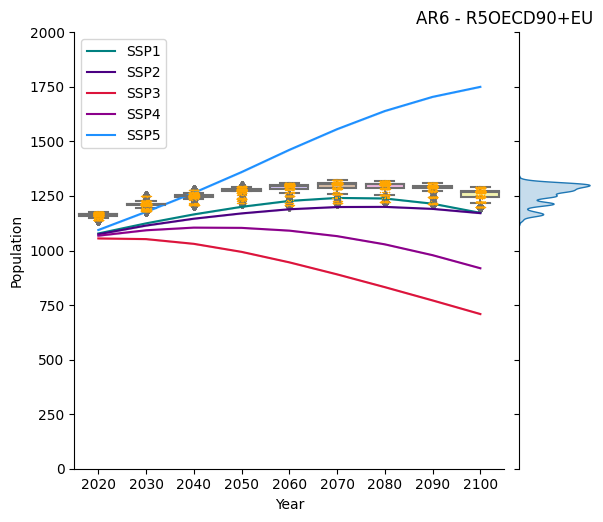

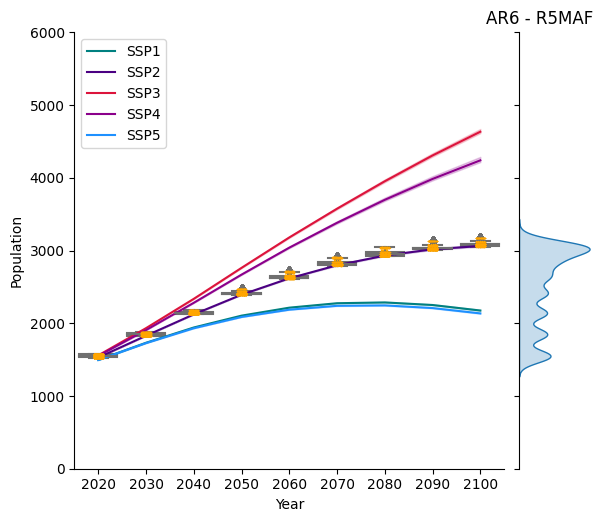

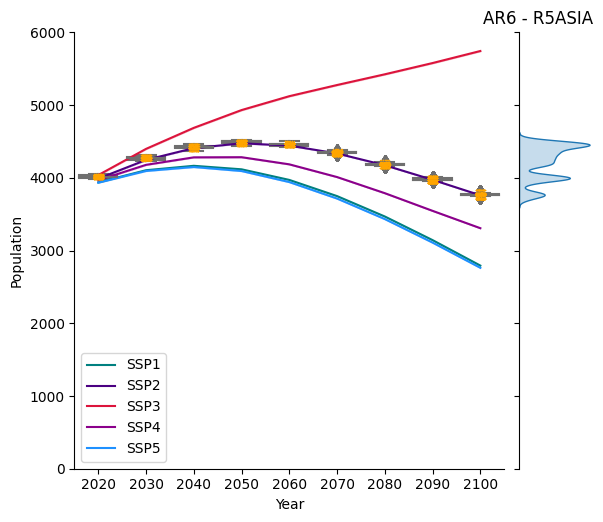

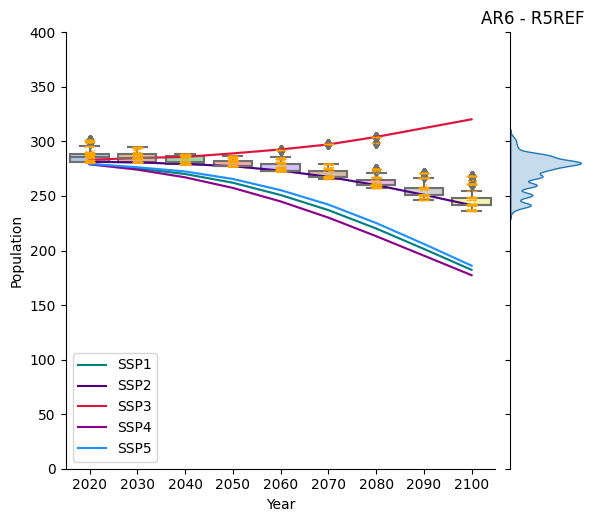

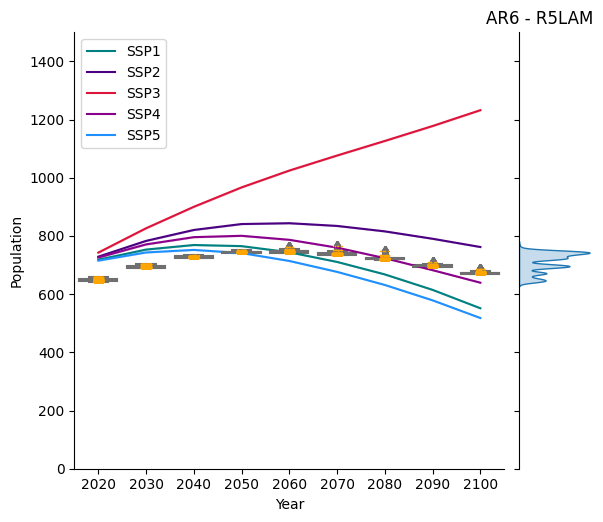

<Figure size 640x480 with 0 Axes>

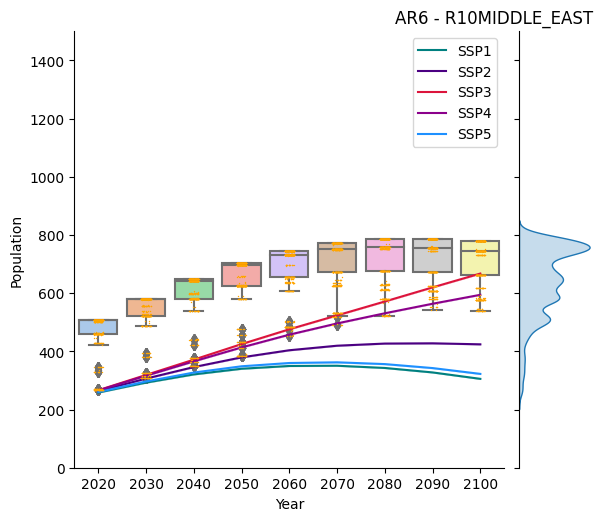

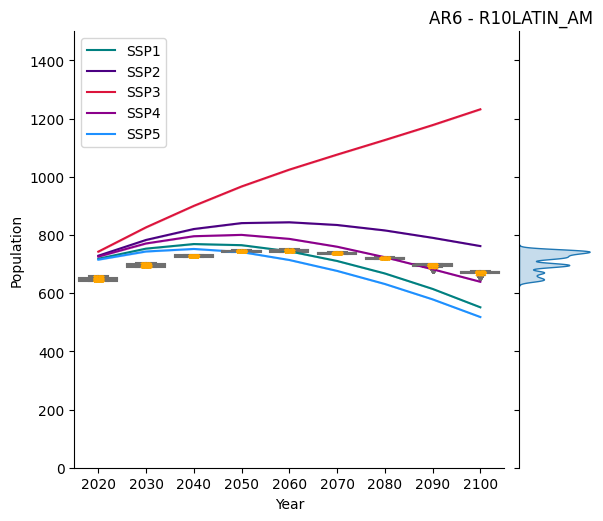

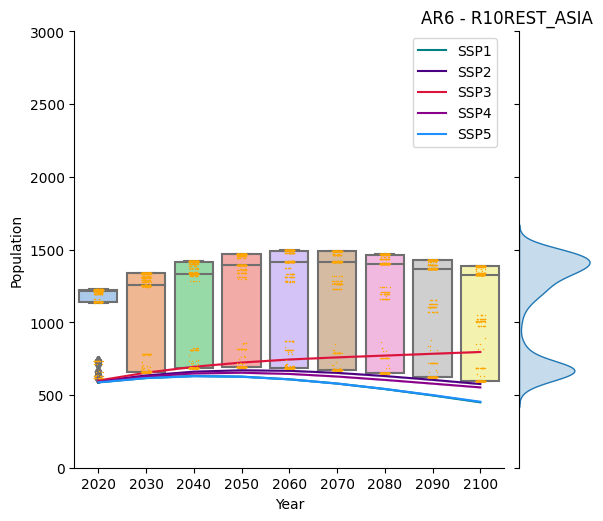

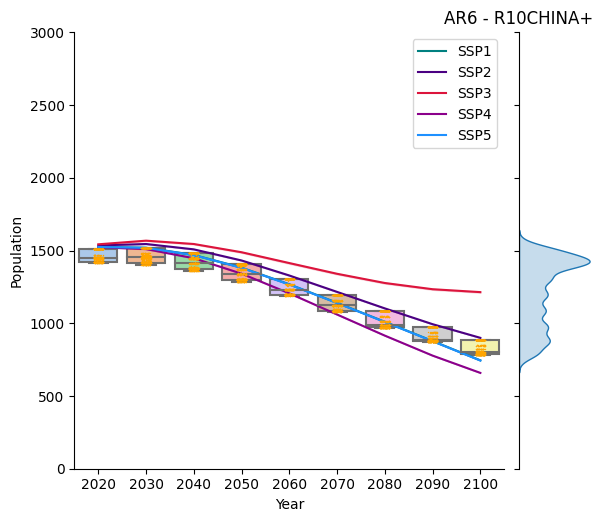

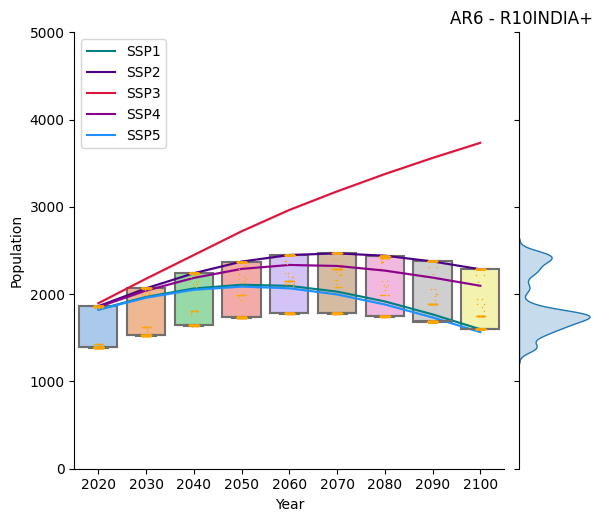

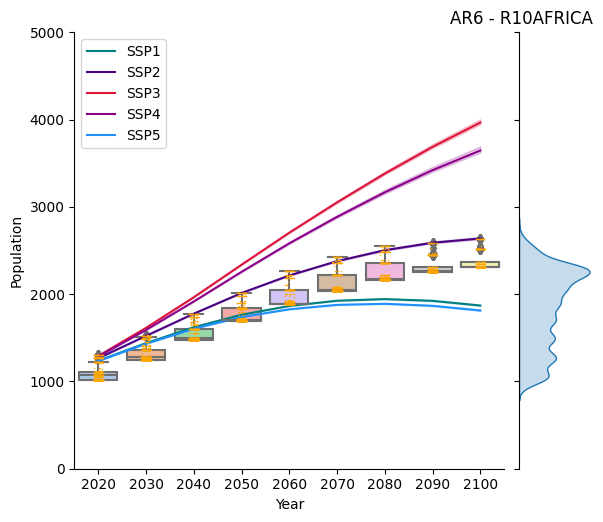

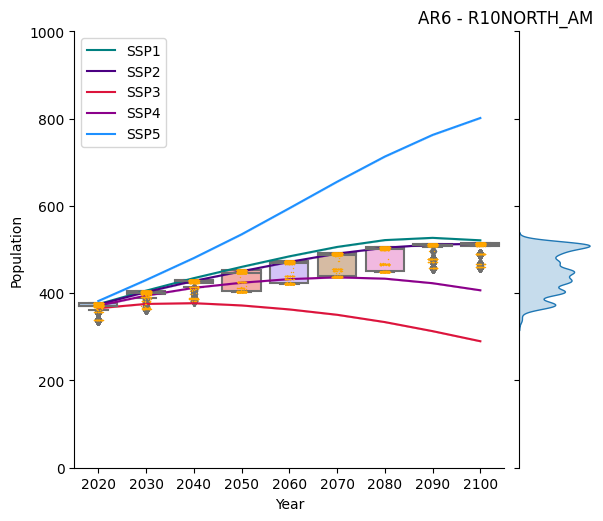

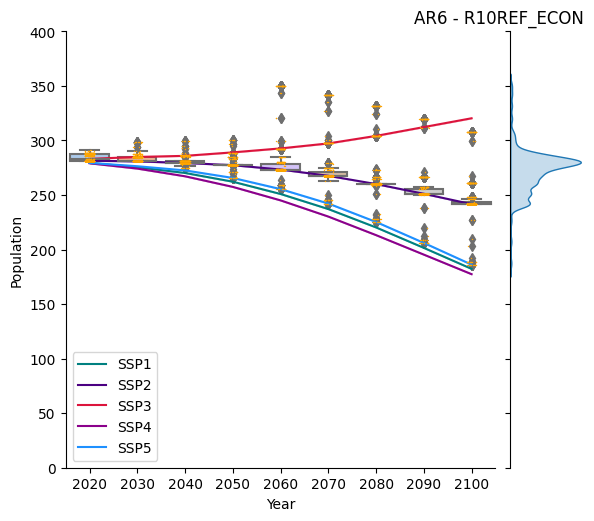

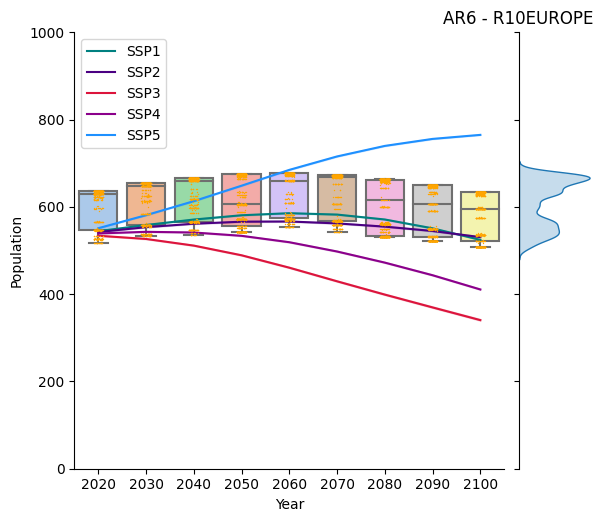

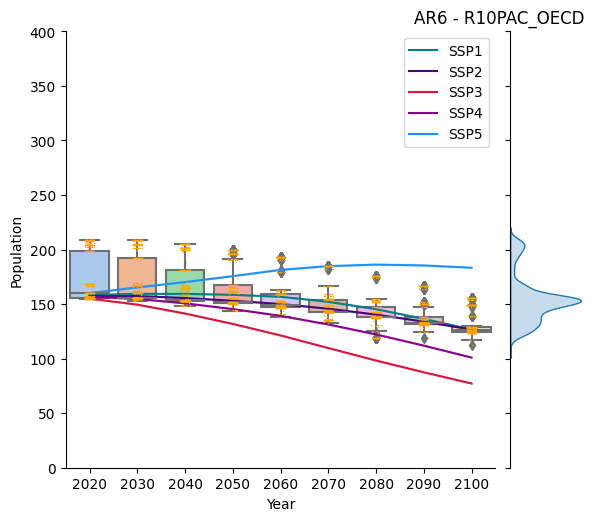

<Figure size 640x480 with 0 Axes>

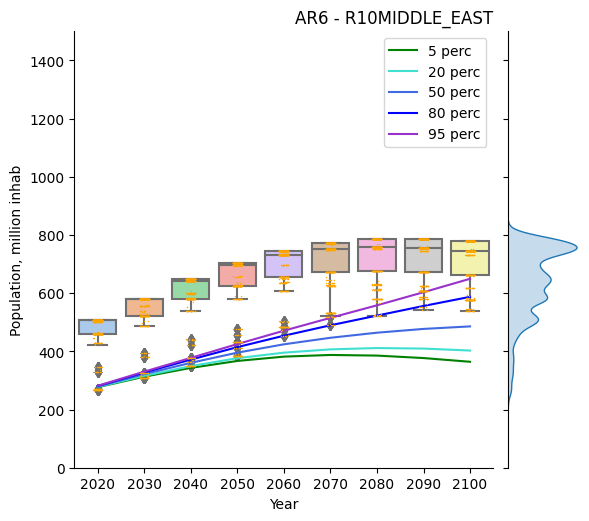

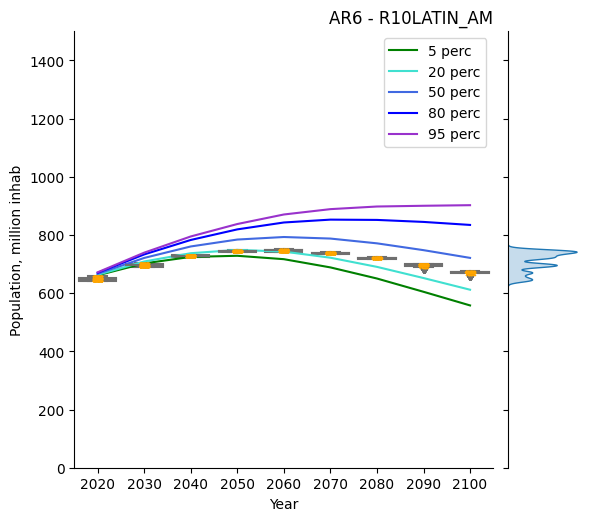

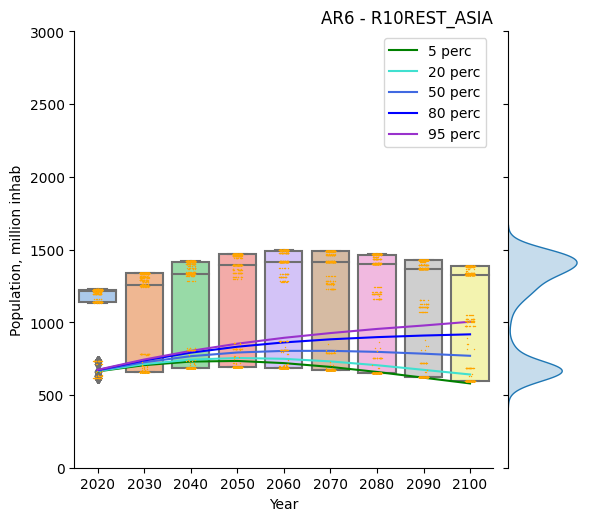

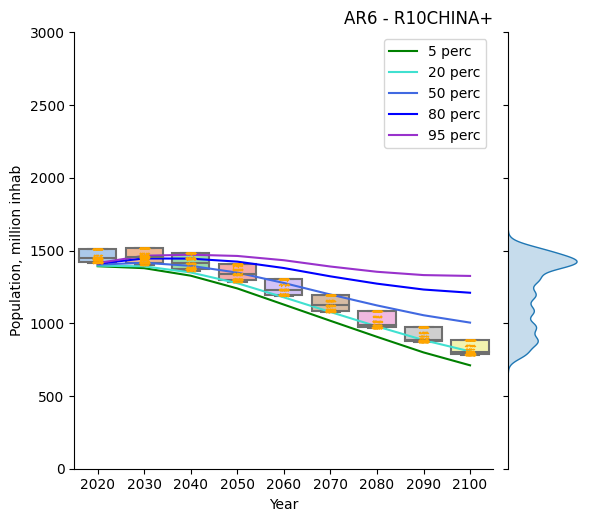

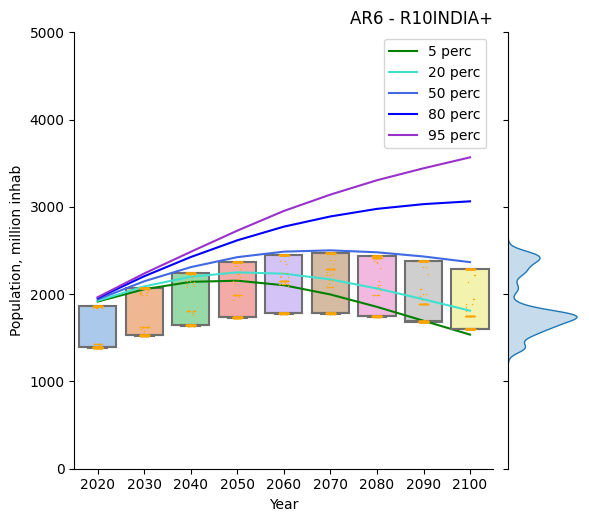

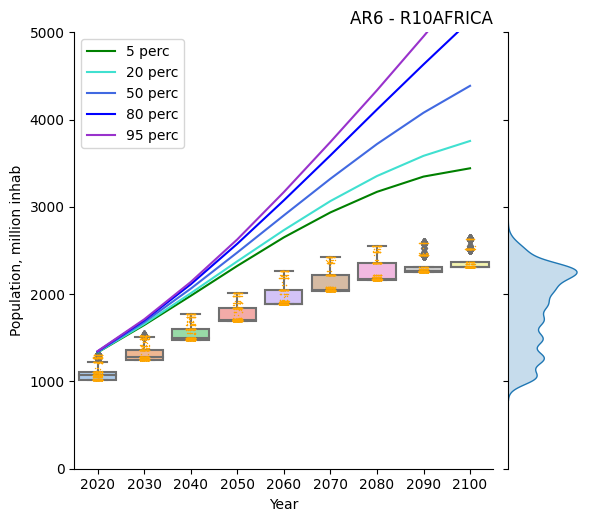

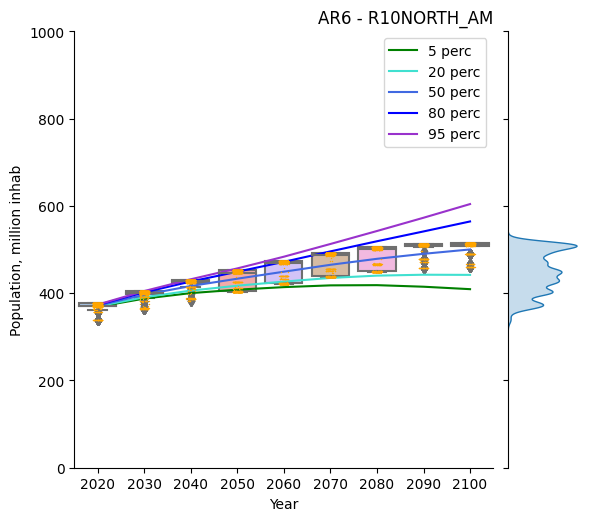

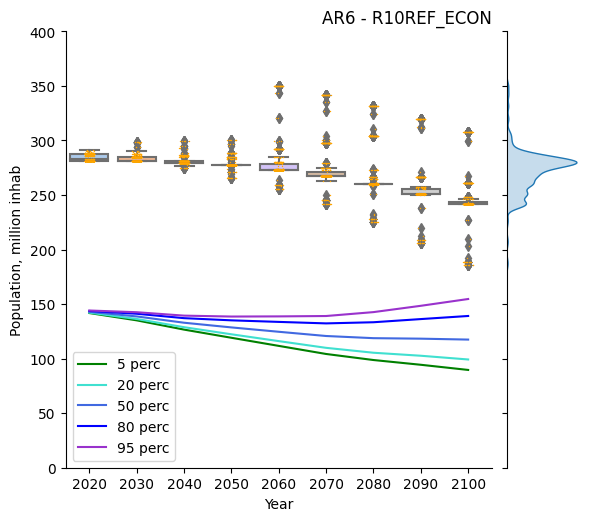

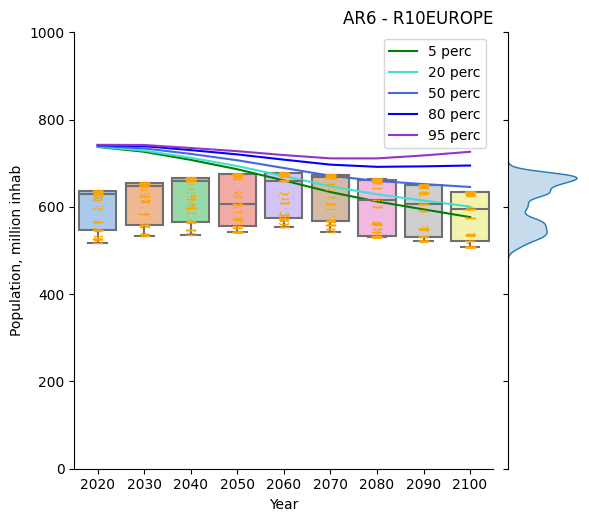

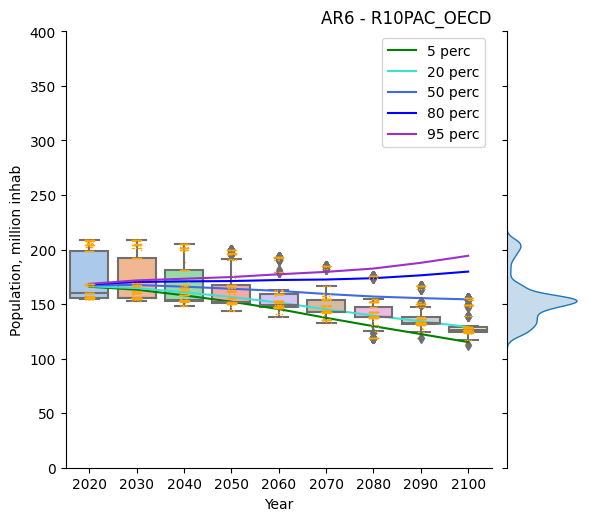

In [20]:
ssp_full = readSSP()
SSPpop = ssp_full[0]
codes = ssp_full[4]
scenarios = ssp_full[5]

SSPpopc = pd.DataFrame(SSPpop)
for o in codes.keys():
    SSPpopc["Country"]  = SSPpopc["Country"].replace(o, codes[o])

SSPpopc = SSPpopc.rename(columns={"Country": "COUNTRY"})
dict5R=createIPCC5R()
SSPpopc5R = SSPpopc.copy(deep=True)
SSPpopc5R["IPCCRegion"] = SSPpopc5R["COUNTRY"]
keys = list(dict5R.keys())[1:]
for o in keys:
    SSPpopc5R["IPCCRegion"]  = SSPpopc5R["IPCCRegion"].replace(dict5R[o],o)


dict10R=createIPCC10R()
SSPpopc10R = SSPpopc.copy(deep=True)
SSPpopc10R["IPCCRegion"] = SSPpopc10R["COUNTRY"]
keys = list(dict10R.keys())[1:]
for o in keys:
    SSPpopc10R["IPCCRegion"]  = SSPpopc10R["IPCCRegion"].replace(dict10R[o],o)

for o in scenarios.keys():
    SSPpopc5R["SCENARIO"]  = SSPpopc5R["SCENARIO"].replace(o, scenarios[o])
    SSPpopc10R["SCENARIO"]  = SSPpopc10R["SCENARIO"].replace(o, scenarios[o])

remove = "PIK GDP-32"
SSPpopc5R = pd.DataFrame(SSPpopc5R .loc[SSPpopc5R.MODEL != remove])
SSPpopc10R = pd.DataFrame(SSPpopc10R .loc[SSPpopc10R.MODEL != remove])

SSPrex5=SSPpopc5R.drop(["REGION", "COUNTRY"], axis=1)
SSPrex10=SSPpopc10R.drop(["REGION", "COUNTRY"], axis=1)

columns = ['MODEL', 'SCENARIO', 'IPCCRegion', 'VARIABLE', 'UNIT', '2020', '2030', '2040', '2050',
       '2060', '2070', '2080', '2090', '2100']


SSPrex5=SSPrex5[columns]
SSPrex10=SSPrex10[columns]
SSPrex5 = SSPrex5.groupby(["MODEL", "SCENARIO", "IPCCRegion", "UNIT"])[syears].sum().reset_index()

SSPrex10 = SSPrex10.groupby(["MODEL", "SCENARIO", "IPCCRegion", "UNIT"])[syears].sum().reset_index()


# SSPs and R5 regions (optional - not in paper)
regions=['R5OECD90+EU', 'R5MAF', 'R5ASIA', 'R5REF', 'R5LAM']
limits = [2000, 6000, 6000, 400, 1500]
lim_dict=dict(zip(regions,limits))
for f,rex in enumerate(regions):
    plt.figure(f)
    iqrlo = 0.25
    iqrup = 0.75
    limit = lim_dict[rex]
    ax = joinplot3b(ar6reg5HI, rex, [iqrlo,iqrup, 10000], SSPrex5, 1, "AR6", years, True, (0,limit))
fmax = len(regions) + 1


# SSPs and R10 regions
regions = ['R10MIDDLE_EAST',
 'R10LATIN_AM',
 'R10REST_ASIA',
 'R10CHINA+',
 'R10INDIA+',
 'R10AFRICA',
 'R10NORTH_AM',
 'R10REF_ECON',
 'R10EUROPE',
 'R10PAC_OECD']

limits = [1500, 1500, 3000, 3000, 5000, 5000, 1000, 400, 1000, 400]
lim_dict=dict(zip(regions,limits))
for f,rex in enumerate(regions):
    f += fmax
    plt.figure(f)
    limit=lim_dict[rex]
    iqrlo = 0.25
    iqrup = 0.75
    ax = joinplot3b(ar6reg10HI, rex, [iqrlo, iqrup, 10000], SSPrex10, 1, "AR6", years, True, (0, limit))
fmax += len(regions) + 1

# UN and R10
regions = ['R10MIDDLE_EAST',
 'R10LATIN_AM',
 'R10REST_ASIA',
 'R10CHINA+',
 'R10INDIA+',
 'R10AFRICA',
 'R10NORTH_AM',
 'R10REF_ECON',
 'R10EUROPE',
 'R10PAC_OECD']

limits = [1500, 1500, 3000, 3000, 5000, 5000, 1000, 400, 1000, 400]
lim_dict=dict(zip(regions,limits))
for f,rex in enumerate(regions):
    f += fmax
    plt.figure(f)
    limit=lim_dict[rex]
    iqrlo = 0.25
    iqrup = 0.75
    undata10 = transformUN(r2015_10, rex, True)
    ax = joinplot4b(ar6reg10HI, rex, [iqrlo, iqrup, 10000], undata10, 1, "AR6", years, True, (0, limit), [])


## Part 11: Appendices

### Figure A.1 
Scenario counts

<AxesSubplot: xlabel='Report', ylabel='Scenario Number'>

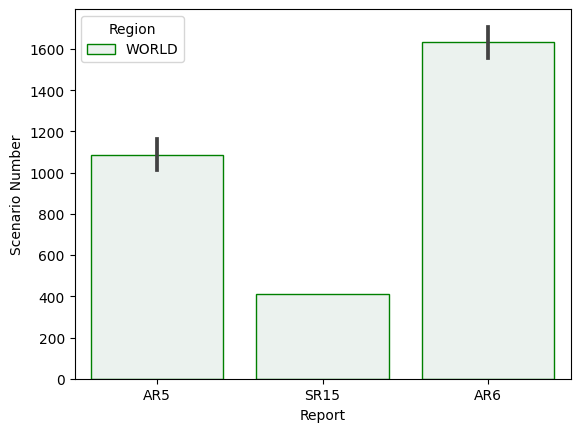

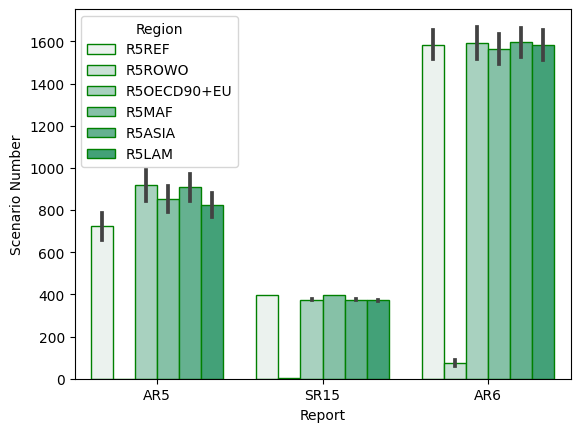

In [21]:
ar5 = counts(ar5HI, "WORLD")
sr15 = counts(ar15HI, "WORLD")
ar6 = counts(ar6HI, "WORLD")

globcount = pd.concat((pd.concat((ar5,sr15)), ar6))
globcount = globcount.reset_index()
globcount = globcount.rename(columns={"index": "Report"})

regcount = pd.DataFrame()
for region in list(set(ar6reg5HI.Region)):  
    ar5reg = counts(ar5HI, region)
    sr15reg = counts(ar15HI, region)
    ar6reg = counts(ar6reg5HI, region)
    regcount = pd.concat((regcount, 
               pd.concat((pd.concat((ar5reg,sr15reg)), ar6reg))))
regcount = regcount.reset_index()
regcount = regcount.rename(columns={"index": "Report"})

plt.figure(1)
colours = sns.color_palette("husl", 5)[2]
sns.barplot(globcount, x="Report", y="Scenario Number", hue="Region", color=colours, edgecolor="green")
plt.figure(2)
colours = sns.color_palette("husl", 5)[2]
sns.barplot(regcount, x="Report", y="Scenario Number", hue="Region", color=colours, edgecolor="green")

### Figure A.2, A.4, and A.6
Scenario counts by project

<Figure size 640x480 with 0 Axes>

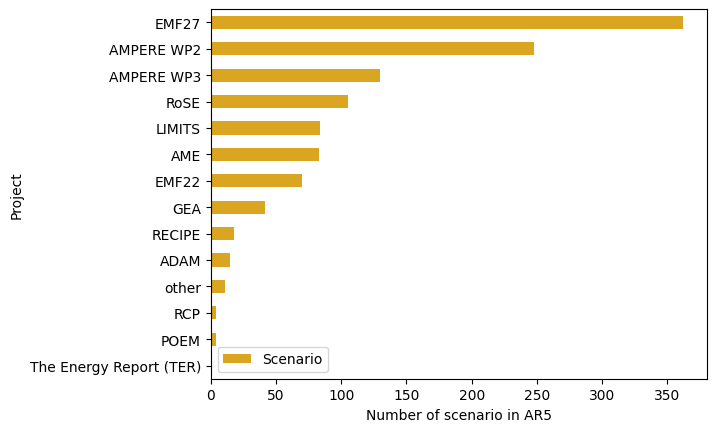

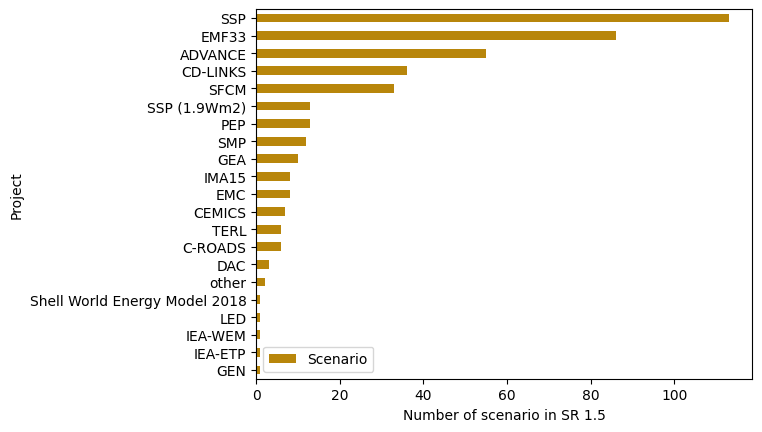

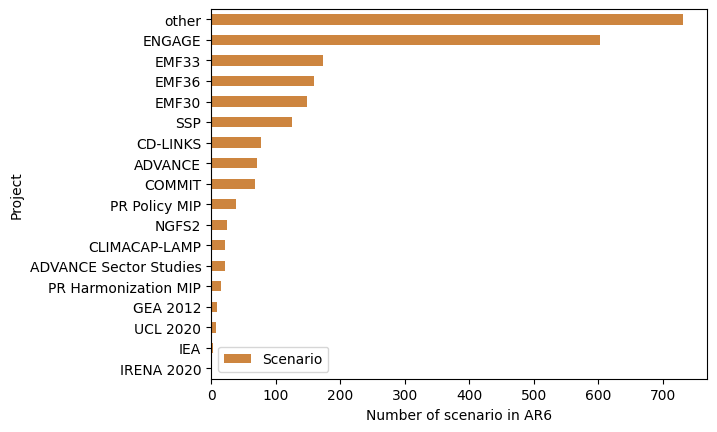

In [22]:
ar_scenarios, ar5meta, ar15meta, ar6meta = readmeta()
srdbases = ["AR5", "SR 1.5", "AR6"]
colours = [ "goldenrod", "darkgoldenrod", "peru"]
for f, fsr in enumerate(srdbases):
    ar = pd.DataFrame(ar_scenarios.loc[ar_scenarios.Report==fsr]).drop("Report", axis=1)
    projects = ar["Project"].transpose()
    ar = ar.reset_index().set_index(projects).drop("index", axis=1)
    plt.figure(f)
    ar.plot.barh(color=colours[f])
    xlabel = ["Number of scenario in " + fsr]
    plt.xlabel(xlabel[0])

### Figure A.3, A.5, and A.7
Scenario counts by model

<Figure size 640x480 with 0 Axes>

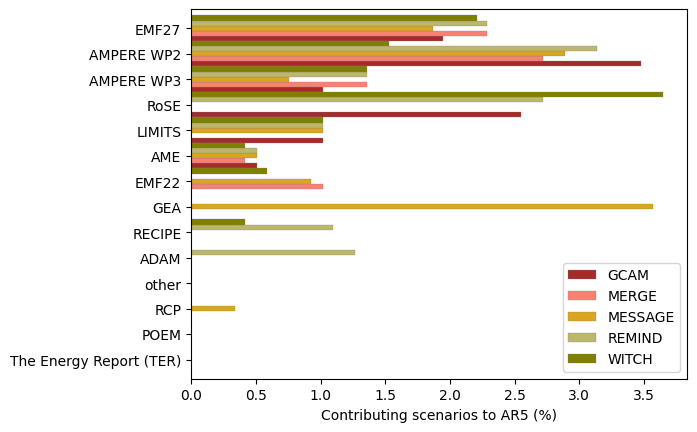

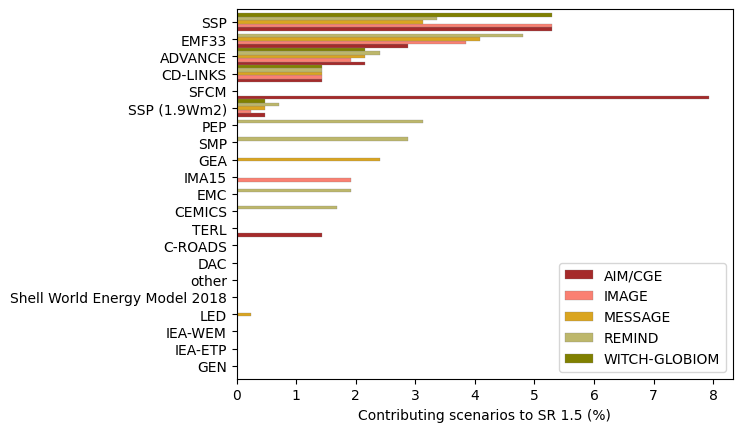

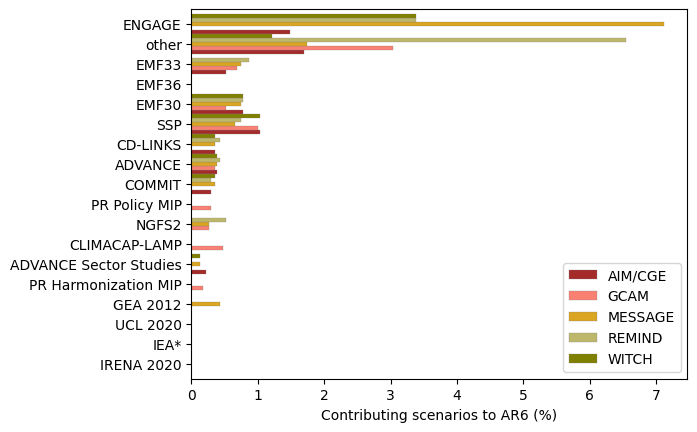

In [23]:

colours = ["brown", "salmon", "goldenrod", "darkkhaki", "olive"]
srdbases = ["AR5", "SR 1.5", "AR6"]
top5full = [["GCAM", "MERGE", "MESSAGE", "REMIND", "WITCH"],
            ["AIM/CGE", "IMAGE", "MESSAGE", "REMIND", "WITCH-GLOBIOM"],
            ["AIM/CGE", "GCAM", "MESSAGE", "REMIND", "WITCH"]]
metadbases = [ar5meta, ar15meta, ar6meta]
for f, fsr in enumerate(srdbases): 
    top5 = top5full[f]
    arsel = pd.DataFrame(metadbases[f][metadbases[f]["Model"].isin(top5)]).drop("Report", axis=1).transpose()
    rename_dict = dict(zip(arsel.columns,top5))
    arselt = arsel[1:].rename(columns=rename_dict)
    plt.figure(f)
    arselt.plot.barh(color=colours, linewidth=0.2, edgecolor="gray", width=1.0)
    xlabel = ["Contributing scenarios to " + fsr + " (%)"]
    plt.xlabel(xlabel[0])

/Users/sara/opt/anaconda3/envs/manet/lib/python3.10/site-packages/seaborn/axisgrid.py:1690: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize=(height, height))


<Figure size 640x480 with 0 Axes>

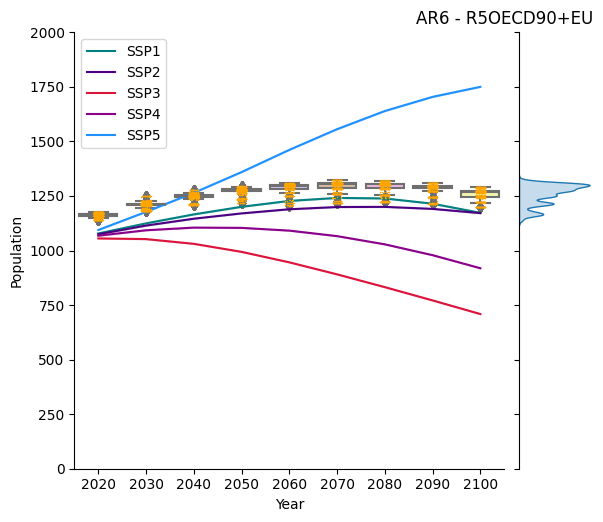

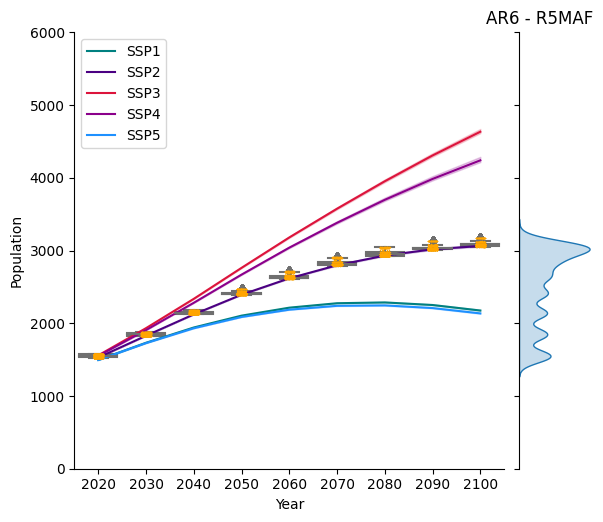

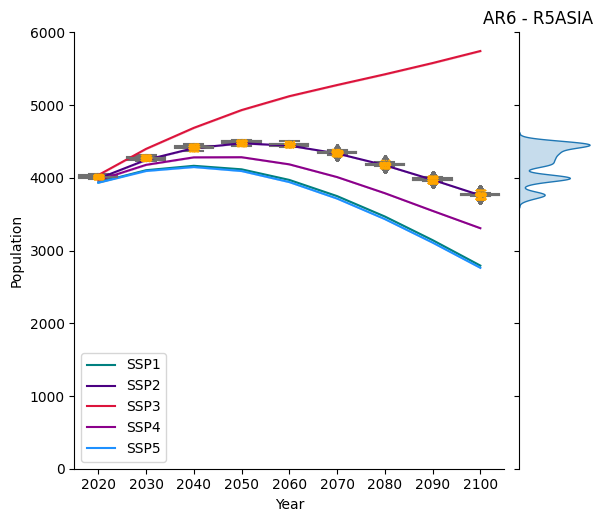

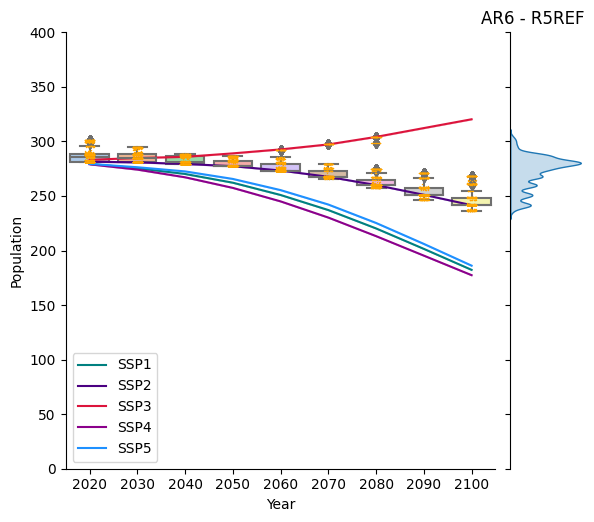

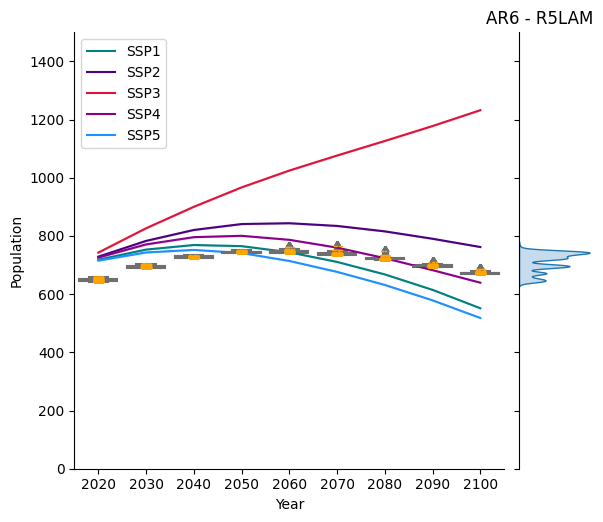

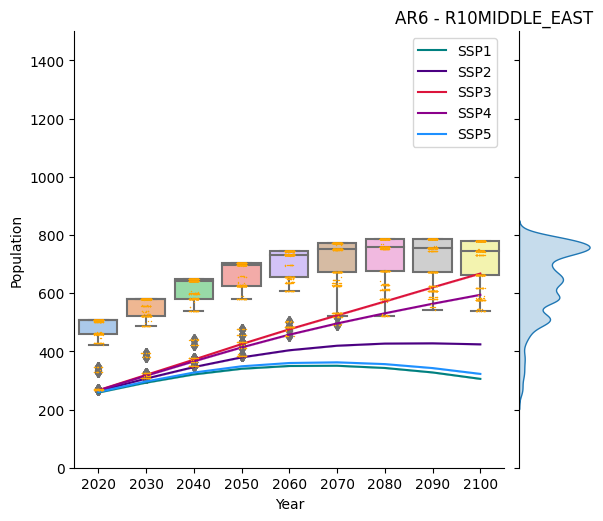

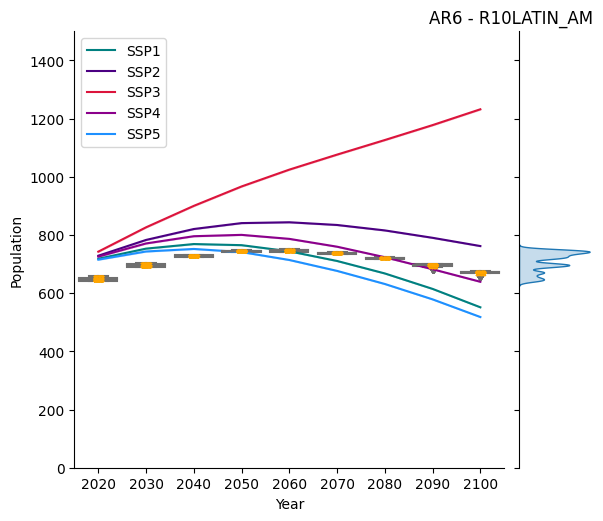

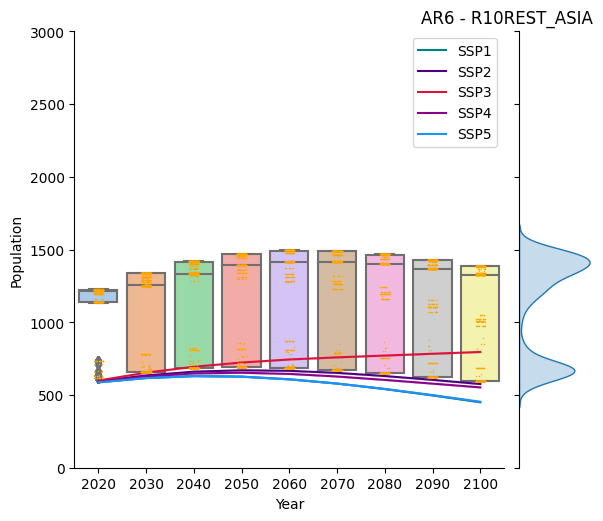

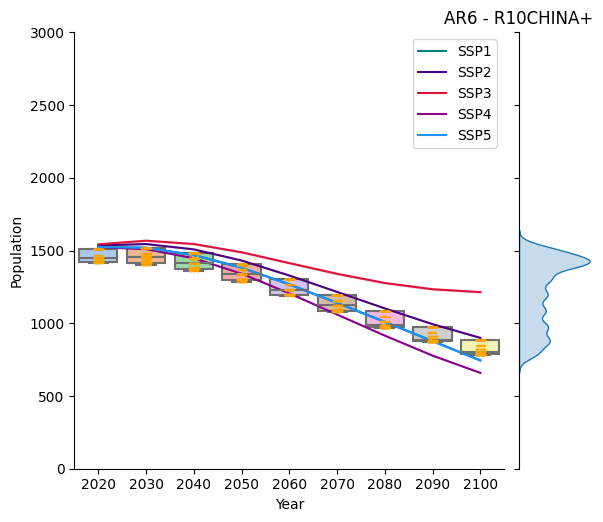

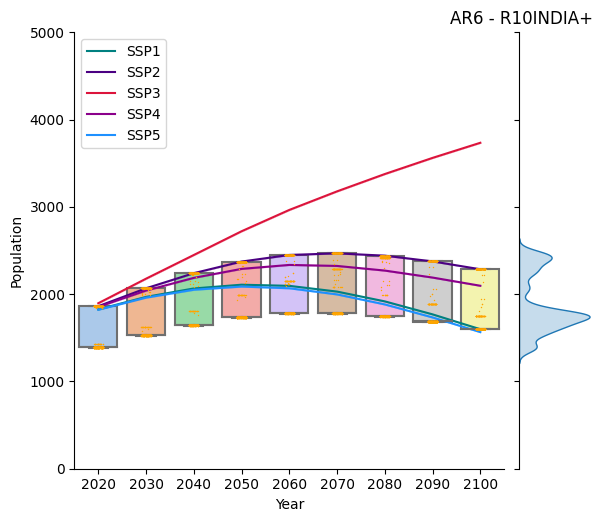

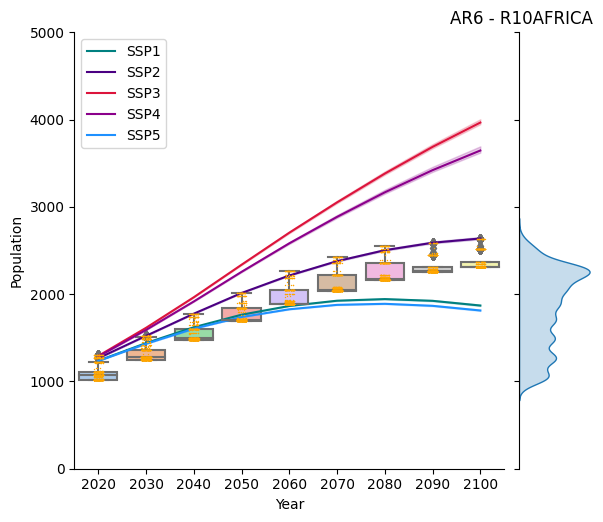

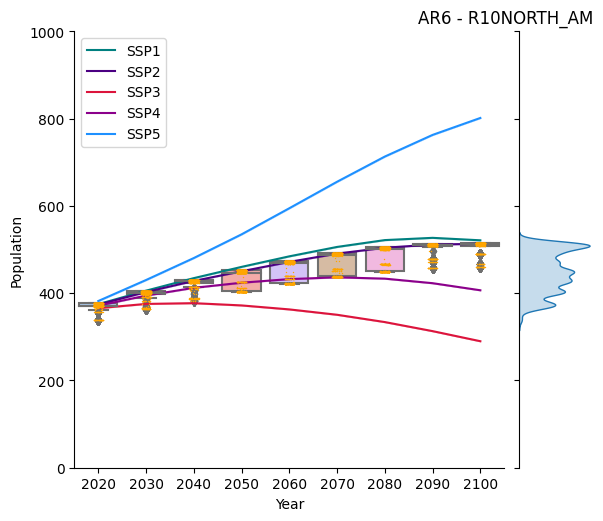

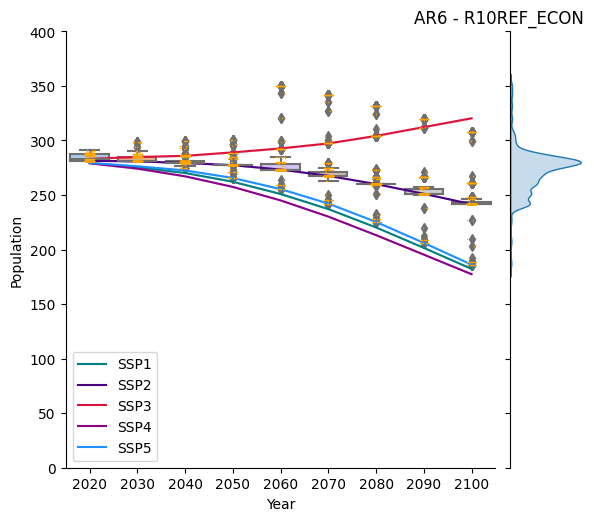

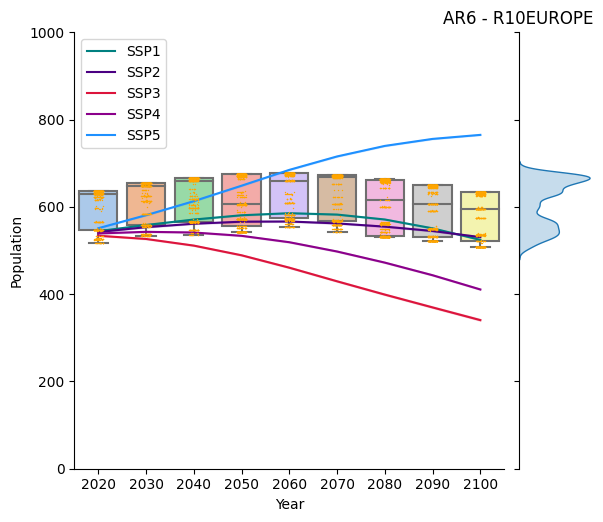

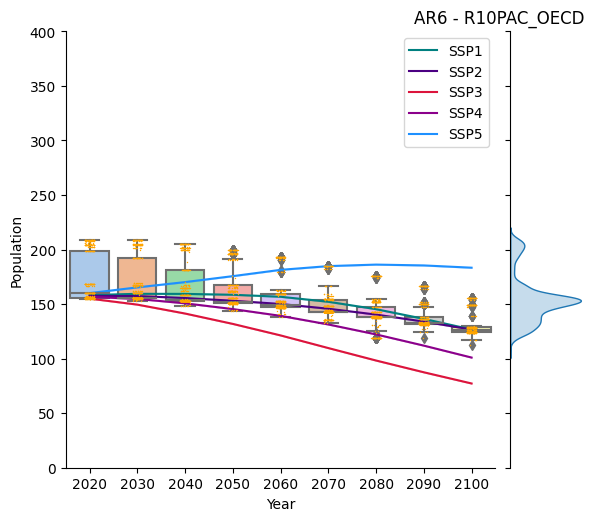

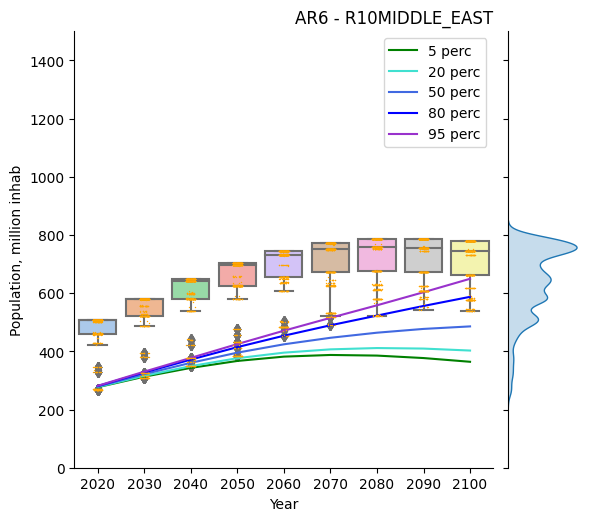

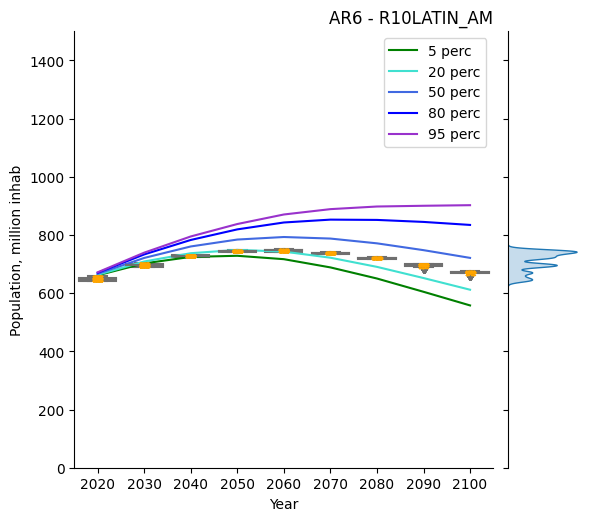

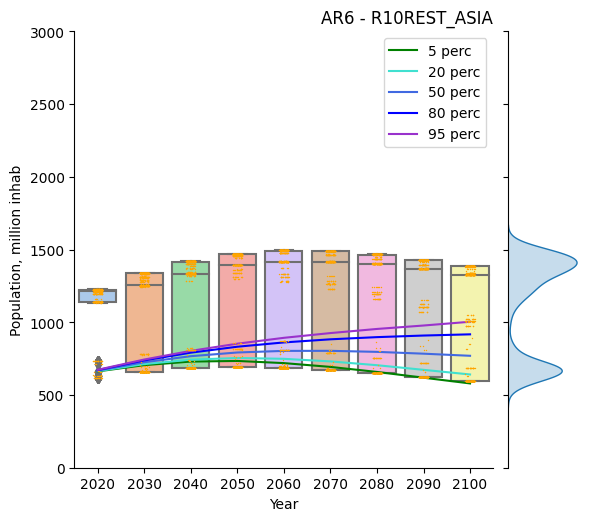

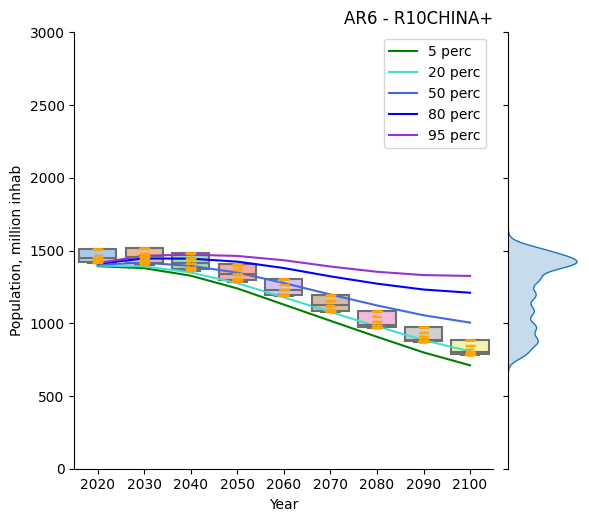

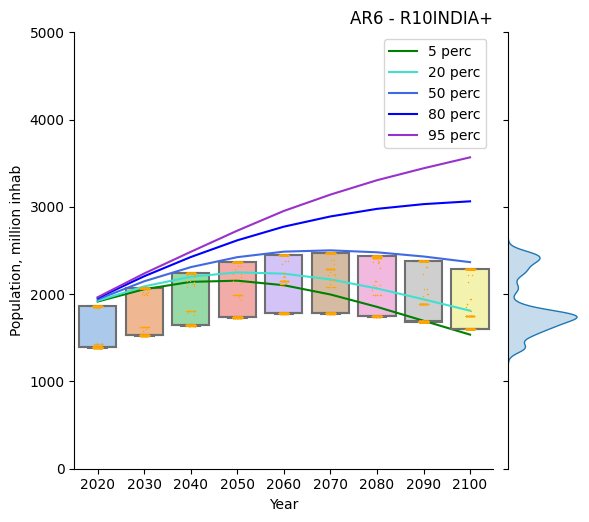

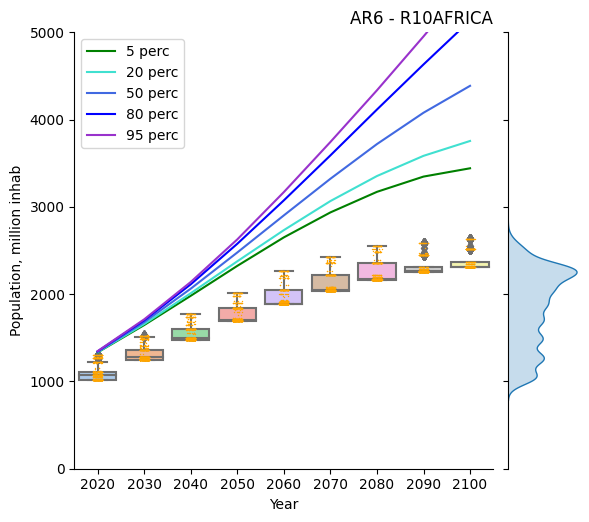

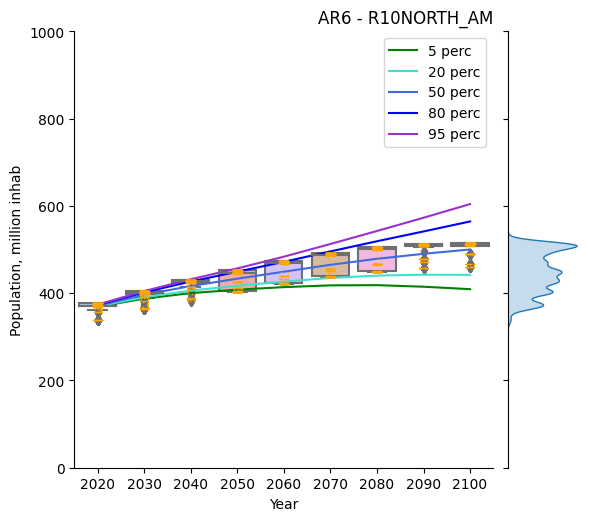

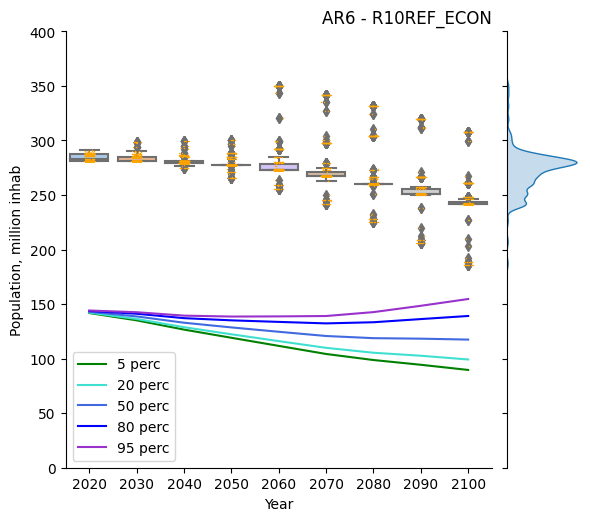

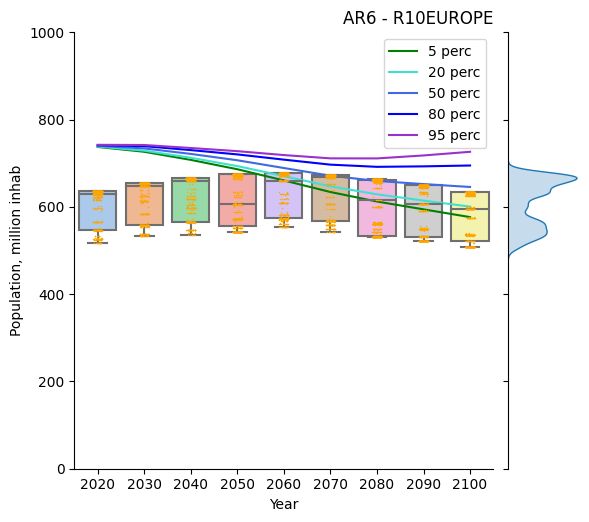

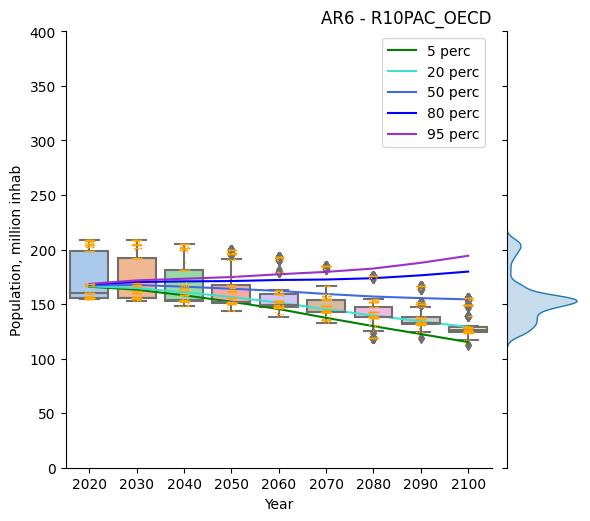

In [24]:
ssp_full = readSSP()
SSPpop = ssp_full[0]
codes = ssp_full[4]
scenarios = ssp_full[5]

SSPpopc = pd.DataFrame(SSPpop)
for o in codes.keys():
    SSPpopc["Country"]  = SSPpopc["Country"].replace(o, codes[o])

SSPpopc = SSPpopc.rename(columns={"Country": "COUNTRY"})
dict5R=createIPCC5R()
SSPpopc5R = SSPpopc.copy(deep=True)
SSPpopc5R["IPCCRegion"] = SSPpopc5R["COUNTRY"]
keys = list(dict5R.keys())[1:]
for o in keys:
    SSPpopc5R["IPCCRegion"]  = SSPpopc5R["IPCCRegion"].replace(dict5R[o],o)


dict10R=createIPCC10R()
SSPpopc10R = SSPpopc.copy(deep=True)
SSPpopc10R["IPCCRegion"] = SSPpopc10R["COUNTRY"]
keys = list(dict10R.keys())[1:]
for o in keys:
    SSPpopc10R["IPCCRegion"]  = SSPpopc10R["IPCCRegion"].replace(dict10R[o],o)

for o in scenarios.keys():
    SSPpopc5R["SCENARIO"]  = SSPpopc5R["SCENARIO"].replace(o, scenarios[o])
    SSPpopc10R["SCENARIO"]  = SSPpopc10R["SCENARIO"].replace(o, scenarios[o])

remove = "PIK GDP-32"
SSPpopc5R = pd.DataFrame(SSPpopc5R .loc[SSPpopc5R.MODEL != remove])
SSPpopc10R = pd.DataFrame(SSPpopc10R .loc[SSPpopc10R.MODEL != remove])

SSPrex5=SSPpopc5R.drop(["REGION", "COUNTRY"], axis=1)
SSPrex10=SSPpopc10R.drop(["REGION", "COUNTRY"], axis=1)

columns = ['MODEL', 'SCENARIO', 'IPCCRegion', 'VARIABLE', 'UNIT', '2020', '2030', '2040', '2050',
       '2060', '2070', '2080', '2090', '2100']


SSPrex5=SSPrex5[columns]
SSPrex10=SSPrex10[columns]
SSPrex5 = SSPrex5.groupby(["MODEL", "SCENARIO", "IPCCRegion", "UNIT"])[syears].sum().reset_index()

SSPrex10 = SSPrex10.groupby(["MODEL", "SCENARIO", "IPCCRegion", "UNIT"])[syears].sum().reset_index()


# SSPs and R5 regions (optional - not in paper)
regions=['R5OECD90+EU', 'R5MAF', 'R5ASIA', 'R5REF', 'R5LAM']
limits = [2000, 6000, 6000, 400, 1500]
lim_dict=dict(zip(regions,limits))
for f,rex in enumerate(regions):
    plt.figure(f)
    iqrlo = 0.25
    iqrup = 0.75
    limit = lim_dict[rex]
    ax = joinplot3b(ar6reg5HI, rex, [iqrlo,iqrup, 10000], SSPrex5, 1, "AR6", years, True, (0,limit))
fmax = len(regions)

# SSPs and R10 regions
regions = ['R10MIDDLE_EAST',
 'R10LATIN_AM',
 'R10REST_ASIA',
 'R10CHINA+',
 'R10INDIA+',
 'R10AFRICA',
 'R10NORTH_AM',
 'R10REF_ECON',
 'R10EUROPE',
 'R10PAC_OECD']

limits = [1500, 1500, 3000, 3000, 5000, 5000, 1000, 400, 1000, 400]
lim_dict=dict(zip(regions,limits))
for f,rex in enumerate(regions):
    f += fmax
    plt.figure(f)
    limit=lim_dict[rex]
    iqrlo = 0.25
    iqrup = 0.75
    ax = joinplot3b(ar6reg10HI, rex, [iqrlo, iqrup, 10000], SSPrex10, 1, "AR6", years, True, (0, limit))
fmax += len(regions)

# UN and R10
regions = ['R10MIDDLE_EAST',
 'R10LATIN_AM',
 'R10REST_ASIA',
 'R10CHINA+',
 'R10INDIA+',
 'R10AFRICA',
 'R10NORTH_AM',
 'R10REF_ECON',
 'R10EUROPE',
 'R10PAC_OECD']

limits = [1500, 1500, 3000, 3000, 5000, 5000, 1000, 400, 1000, 400]
lim_dict=dict(zip(regions,limits))
for f,rex in enumerate(regions):
    f += fmax
    plt.figure(f)
    limit=lim_dict[rex]
    iqrlo = 0.25
    iqrup = 0.75
    undata10 = transformUN(r2015_10, rex, True)
    ax = joinplot4b(ar6reg10HI, rex, [iqrlo, iqrup, 10000], undata10, 1, "AR6", years, True, (0, limit), [])
